In [1]:
import os
from collections import Counter
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('styles/datafantic-right.mplstyle')
tqdm.pandas(ncols=50)

In [2]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

**План статьи**

1. Гипотеза достаточно очевидная: в 2022 году репрессии против гражданского общества выросли. Это будет видно на количестве административных дел (уголовных тоже, но они с задержкой попадают на ГАС “Правосудие”), которые проходят в российских судах. 
2. Дальше пока предварительно так: одна статья КоАП или УК — одна глава в тексте с комментариями экспертов и наиболее заметными случаями. В итоге получить хронологию года через судебные дела. 
    Какие статьи мы берём для анализа:
- 20.2 КоАП. Нарушение установленного порядка организации либо проведения собрания, митинга, демонстрации, шествия или пикетирования. Основная репрессивная статья против тех, кто участвует или организует митинги.
- 19.3 КоАП. Неповиновение законному распоряжению сотрудника полиции — ещё одна статья, по которой часто задерживают на митинге.
- 214 УК. Вандализм. Протест против войны выражается не только в митингах, но и в различных антивоенных граффити и надписях. 
- 207 УК. Заведомо ложное сообщение об акте терроризма. В частности по этой статье проходили массовые обыски у активистов в Санкт-Петербурге, которых полиция подозревала в минировании отдела полиции. 

Статьи, которые приняли после 24 февраля. 

- 20.3.3 КоАП. Публичные действия, направленные на дискредитацию использования Вооруженных Сил Российской Федерации
- 19.3 КоАП. Неповиновение законному распоряжению сотрудника полиции

Статьи за уклонение от мобилизации

- 21.5 КоАП РФ. Неисполнение гражданами обязанностей по воинскому учету
- 328 УК РФ. Уклонение от прохождения военной и альтернативной гражданской службы

Какие-то статьи ещё добавлю в процессе исследования

**Что можно узнать из этих данных:** 
    - кол-во судебных приговров: стало ли больше судебных приговоров из-за антивоенных протестов, насколько больше по сравнению с прошлым годом, который тоже был протестным.
    - как новые статьи отразились на судебной практике. Есть гипотеза, что часть протоколов стали оформлять не по митинговой 20.2, а по новой 20.3.3
    - региональные аномалии. в каких регионах судебных приговоров больше и почему? изменилась ли как-нибудь география протестов по сравнению с прошлым годом?
    - сколько разных административных статей идут в одном судебном деле. например часто встречается 20.2 (нарушения правил митинга) и 19.3 (Неповиновение законному распоряжению сотрудника полиции) сколько разных административных статей в одном деле. Какие пары и как часто идут в одном судебной разбирательстве
    - ...
    - также на сайте ГАС "Правосудия" есть массив с актами судебных приговоров -- для второй части исследования

**Эксперты:**

- Алёна Архипова, антрополог, ведёт тг-канал, тоже обновляет даные по судебным приговорам
- ОВД-инфо
- Информационно аналитический центр СОВА

**Данные:**

- ГАС Правосудие
- https://data.ovdinfo.org/

Этот материал можно обновлять. Например, раз в месяц собирать данные с ГАС “Правосудия” и делать небольшой материал с инфографикой. 

**ToDo**:

**Нет приговоров**:
* 207.3 УК — «фейки»
* 280.3 УК — «дискредитация вооруженных сил РФ»
* 280.4 УК — «призывы к санкциям»
* подсчитать процент женщин в делах в 2021 и 2022 году

## Prepare dataset

In [3]:
df = pd.read_csv('data/scrape-12-2022.csv')

In [4]:
df_short = df.copy()

# Делаем общий признак со статьёй
df_short['article'] = df_short.u_case_user_article.combine_first(
    df_short.case_common_parts_law_article
)

df_short['article'] = df_short.article.combine_first(
    df_short.case_document_category_article
)

# Извлекаем временные признаки
df_short.case_user_entry_date = pd.to_datetime(df.case_user_entry_date, format='%d.%m.%Y')
df_short['year'] = df_short.case_user_entry_date.dt.year
df_short['month'] = df_short.case_user_entry_date.dt.month
df_short['week'] = df_short.case_user_entry_date.dt.isocalendar().week

# Уголовная или административная статья
df_short['is_criminal'] = df_short.case_user_doc_number.str\
                            .contains('Уголовное').replace({True: 1, False: 0})
# ФИО подсудимого
df_short['user_name'] = df_short.u_common_case_defendant_name.combine_first(
    df_short.adm_case_user_name
)

# Убираем лишние признаки
df_short = df_short.drop(columns=[
    'link',
    'adm_case_user_name',
    'u_common_case_defendant_name',
    'u_case_user_article',
    'case_common_parts_law_article',
    'case_document_category_article'
])

In [5]:
df_short.user_name = df_short.user_name.replace('Информация скрыта', np.nan)

In [6]:
# создаём признак пола подсудимого

def get_gender(name):
    count = {'Fem':0, 'Masc':0, 'Neut':0}
    doc = Doc(name)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        if token.pos == 'PROPN':
            if 'Gender' in token.feats.keys():
                count[token.feats['Gender']] += 1
    if count['Fem'] >= count['Masc']:
        return 'Female'
    return 'Male'

df_short['gender'] = \
        df_short.user_name.progress_apply(lambda x: get_gender(x) if pd.notnull(x) else x)

100%|██████| 24304/24304 [01:30<00:00, 269.97it/s]


In [9]:
df_short[['user_name', 'gender']].sample(10)

user_name  gender
20179         Лапшин Вячеслав Юрьевич    Male
837        Шуваев Сергей Валентинович    Male
19924      Кармокова Лариса Хусеновна  Female
1653   Александров Аркадий Николаевич    Male
5290       Корниенко Алена Михайловна  Female
22817            Рупп Антон Сергеевич    Male
12336        Гоглев Валерий Сергеевич    Male
20812          Легкий Сергей Иванович    Male
16249  Тыртышников Иван Александрович    Male
17701    Иванов Алексей Владиславович    Male

In [10]:
def plot_article(data, resample_by: str='w', title:str=None):
    (
    data
    .set_index('case_user_entry_date')
    .resample(resample_by)
    .size()
    .plot()
    .set_title(title)
    );

# EDA

## Сравнение по всем статьям

Если сравнивать по всем статьям, то 2022 год уже обгоняет предыдущих примерно на 200 дел. Причем нужно учитывать задержку, с которой публикуются приговоры на ГАС "Правосудии" и тот факт, что часть дел 2022 года ещё находятся в производстве. Самый последний приговор в датасете был вынесен 25 октября 2022 года.

In [13]:
df_short.case_user_entry_date.max()

Timestamp('2022-10-25 00:00:00')

In [14]:
# сколько всего дел за 2021 и 2022 есть в датасете
df_short.groupby('year', as_index=False).size()

year   size
0  2021  12073
1  2022  12231

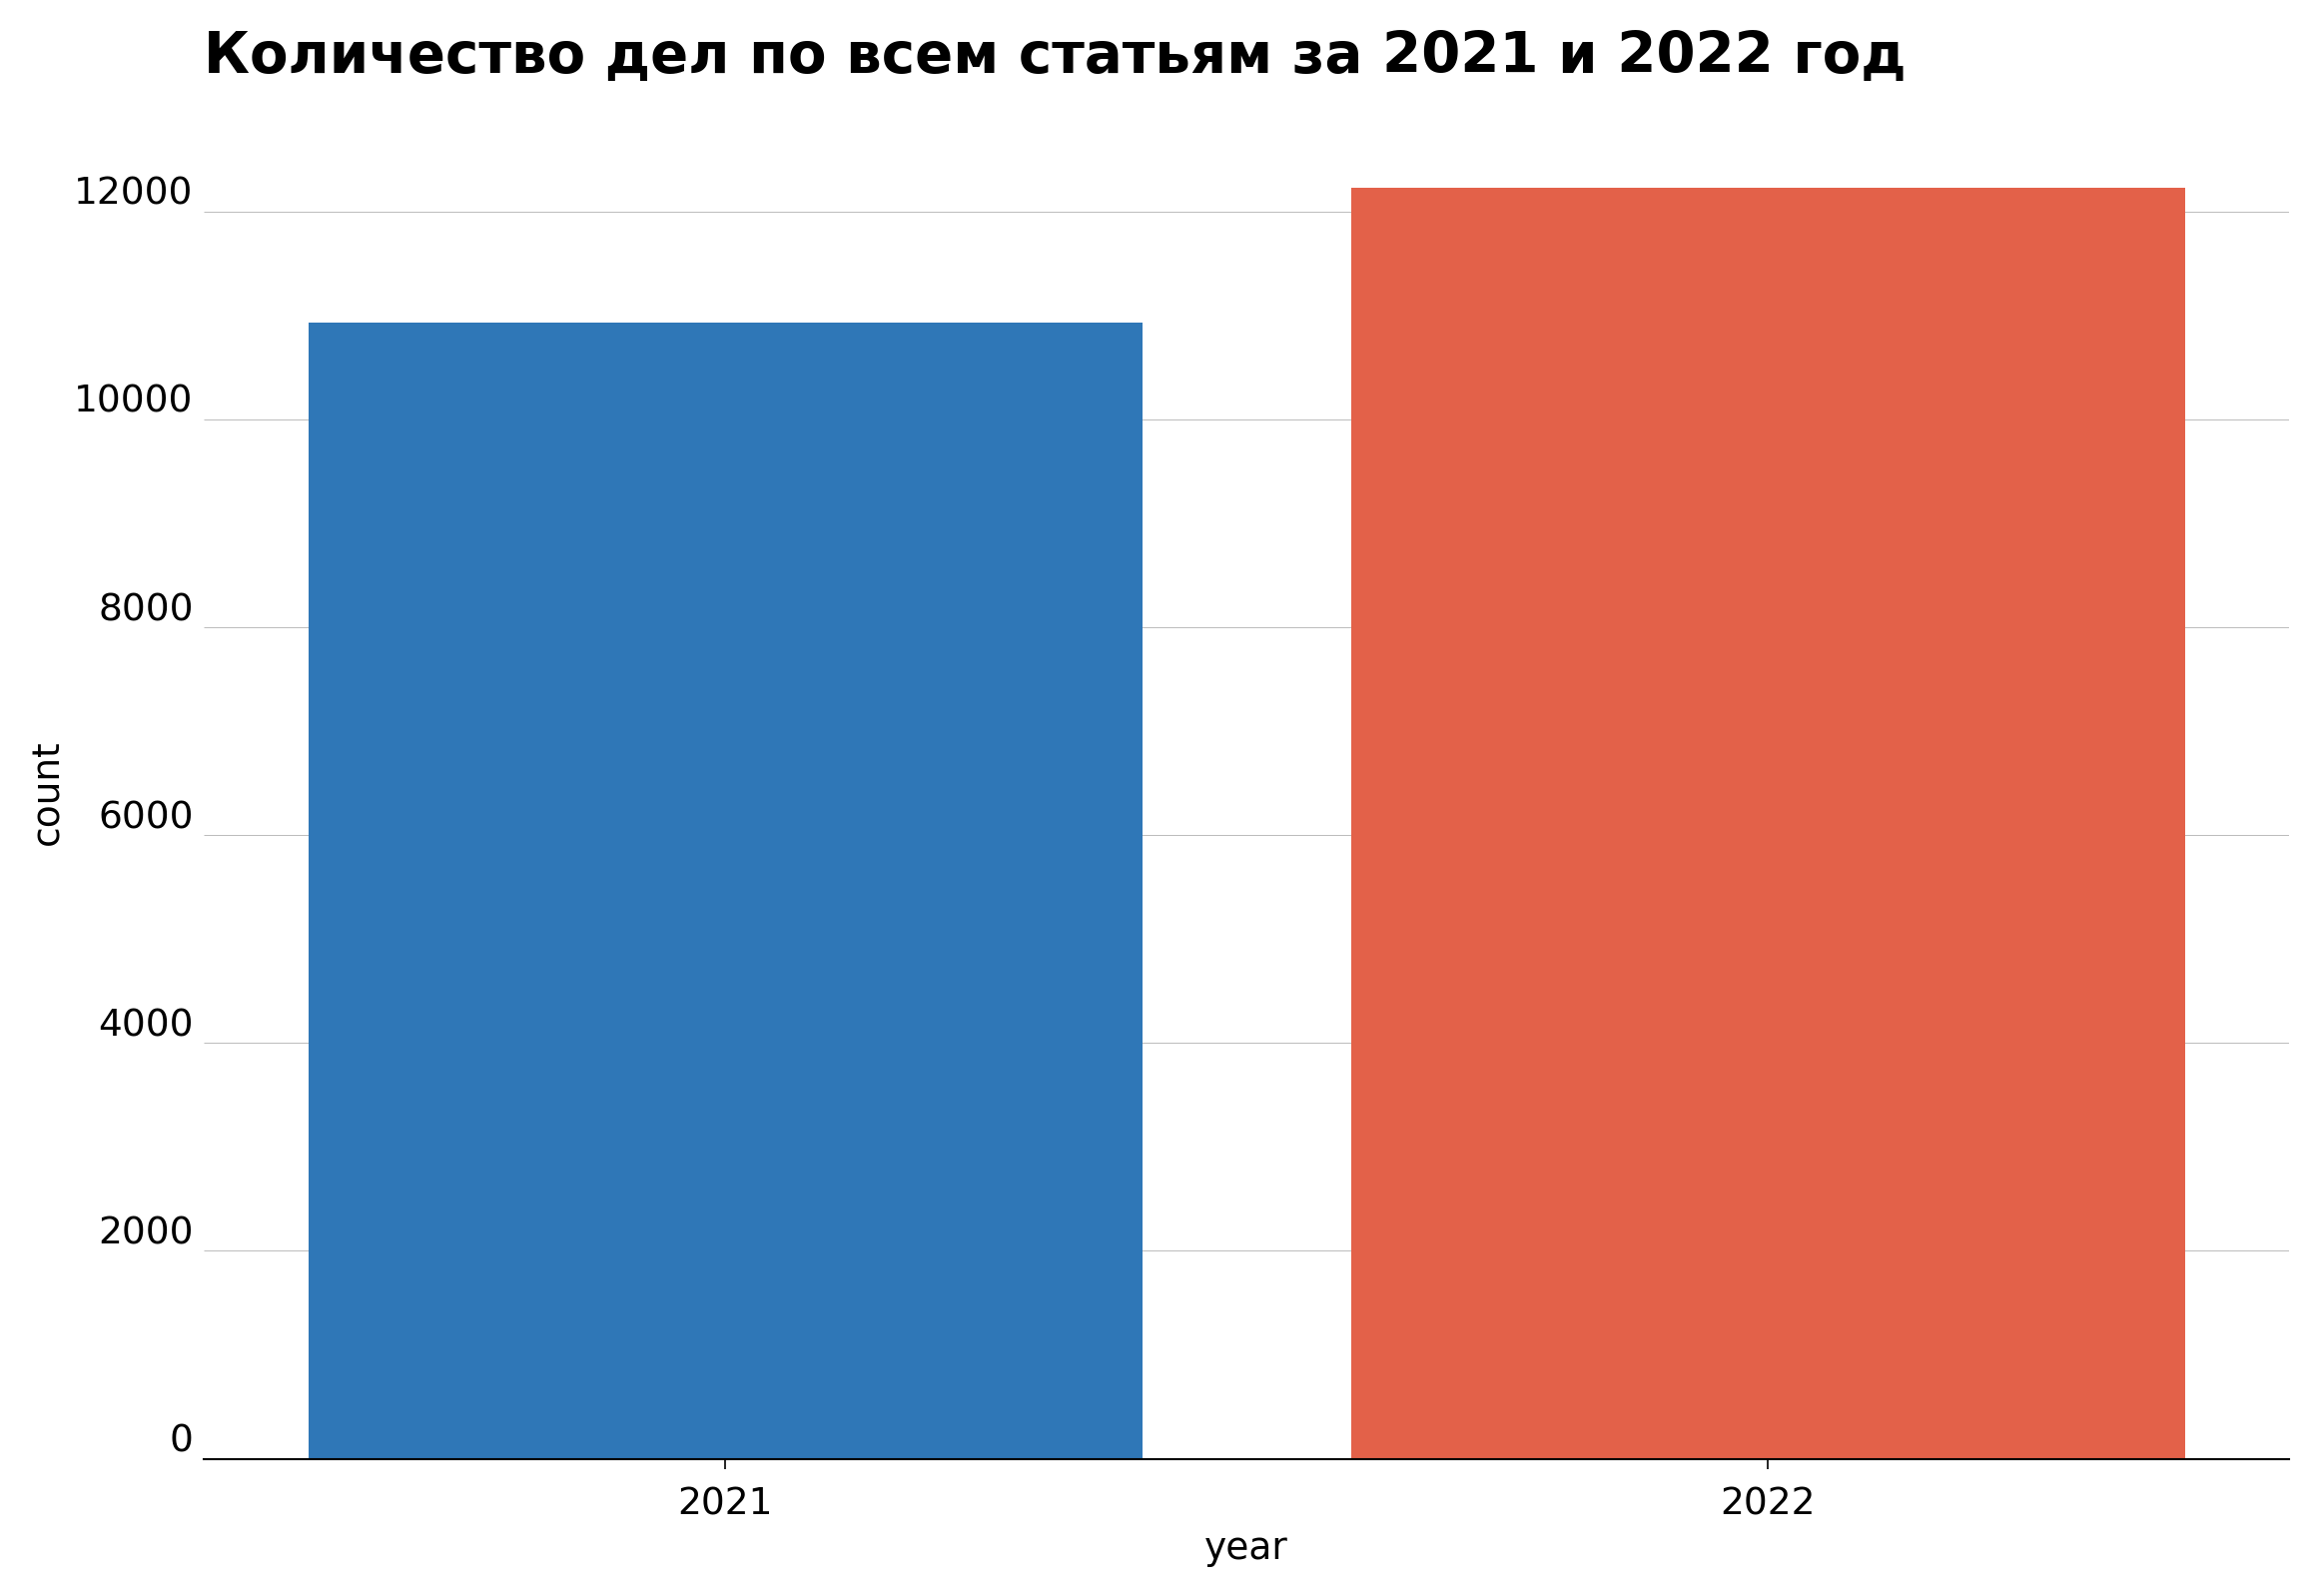

In [15]:
# сколько всего дел за 2021 и 2022 есть в датасете за 10 месяцев

sns.countplot(
    data=df_short[df_short.month <= 10], 
    x='year',
).set_title('Количество дел по всем статьям за 2021 и 2022 год');

In [ ]:
# fig = px.histogram(df_short[df_short.month <= 6], x='year', color='year', barmode='group')
# fig.update_layout(
#     xaxis_title=None,
#     yaxis_title='Количество дел',
#     legend_title='Год',
# #     plot_bgcolor='rgba(0,0,0,0)'

# )
# fig.update_xaxes(visible=False, showticklabels=False)

В первую очередь проверим как эти статьи распределились по времени. Чтобы немного сгладить график будем агрегировать приговоров за неделю. За два года получается четыре заметных пика:
* начало 2021 года - возвращение Навального в Россию, начало протестов за свободу Алексея Навального
* апрель-май 2021 года - продолжение протестов за Навального
* март 2022 - протесты против войны
* конец сентября - начало мобилизации в России

При этом видно, что кол-во приговоров в 2022 году спадает не так резко как 2021. Это скорее всего связано с новыми "антивоенными" статьями.

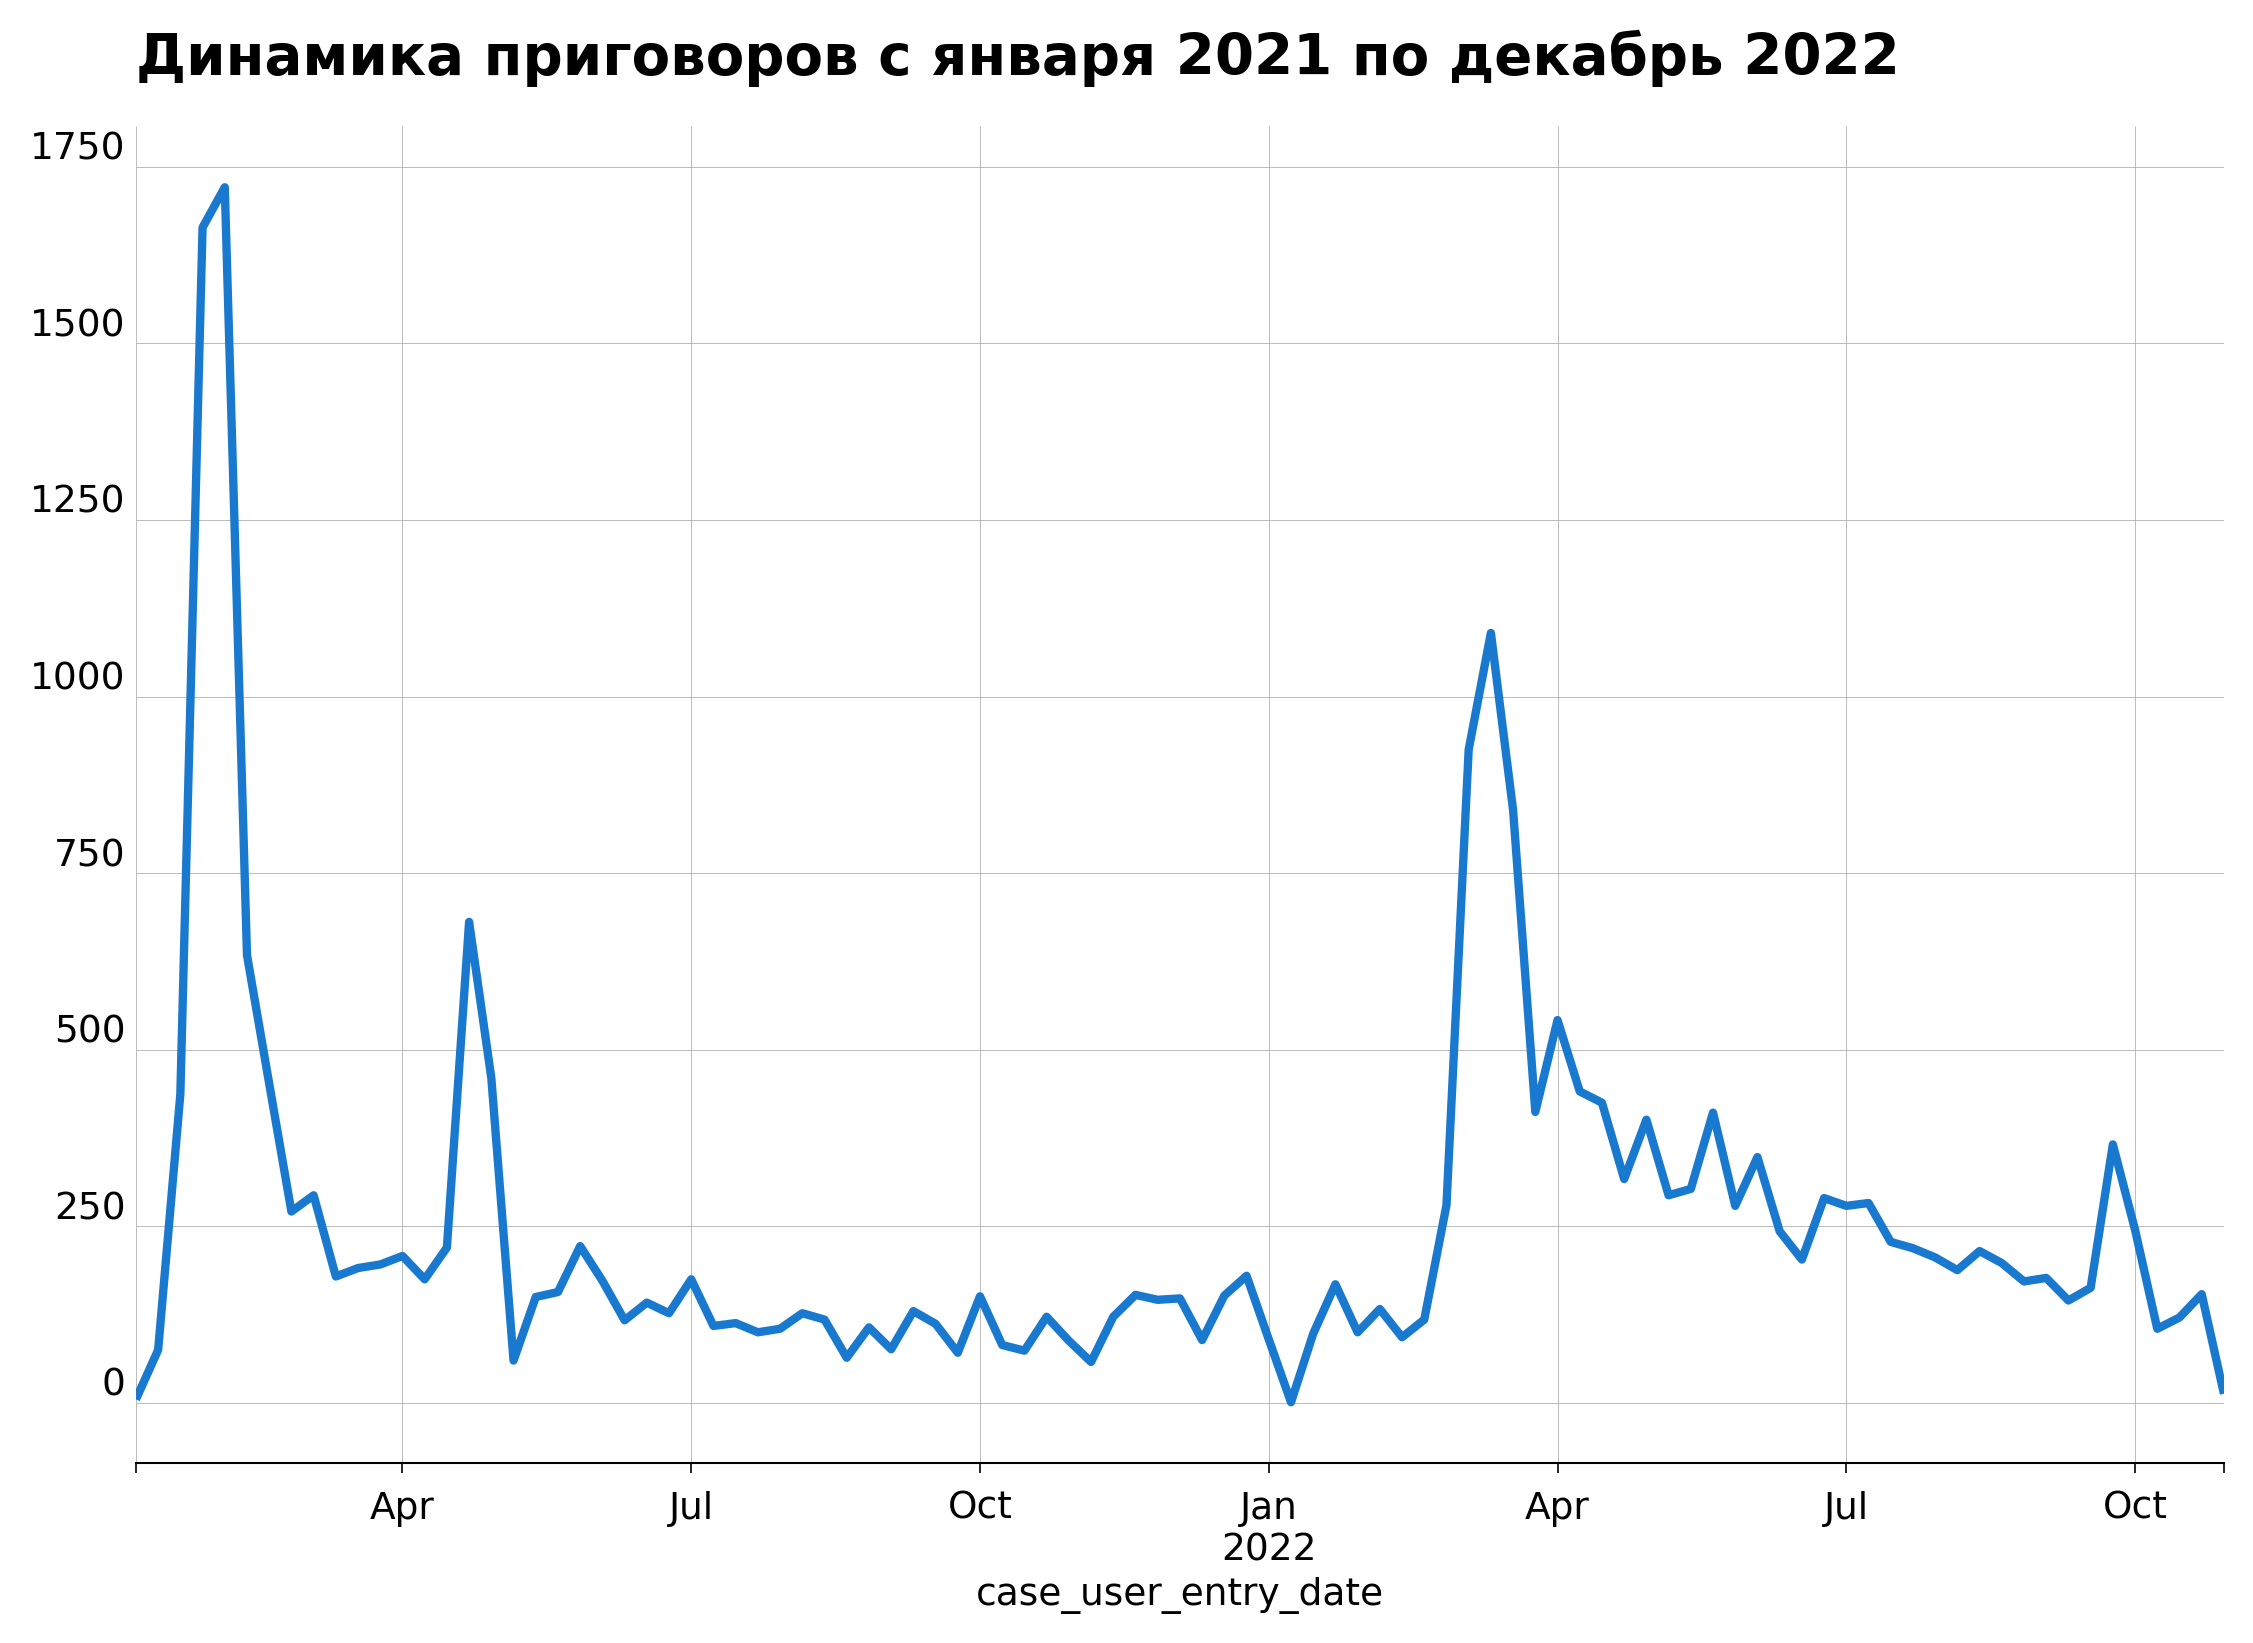

In [16]:
plot_article(
    data=df_short,
    resample_by='w',
    title='Динамика приговоров с января 2021 по декабрь 2022'
)

In [17]:
fig = px.line(df_short.set_index('case_user_entry_date').resample('w').size())

fig.update_layout(
    title="Динамика административных дел с января 2021 по июль 2022",
    xaxis_title="Год",
    yaxis_title="Количество приговоров",
    showlegend=False
)

fig.show()

In [ ]:
# (
#     df_short[df_short.is_criminal == 1].set_index('case_user_entry_date')
#     .resample('m')
#     .size()
#     .plot()
#     .set_title('Динамика уголовных дел с января 2021 по июль 2022')
# );

## 20.2 КоАП. Нарушение установленного порядка организации либо проведения собрания, митинга, демонстрации, шествия или пикетирования

Практически такой же график получается, если визуализировать только статью 20.2 КоАП - это наиболее распространённая статья в датасете. Пики по приговорам приходятся на разгар уличных акций. Причем в 2022 они заметно ниже.

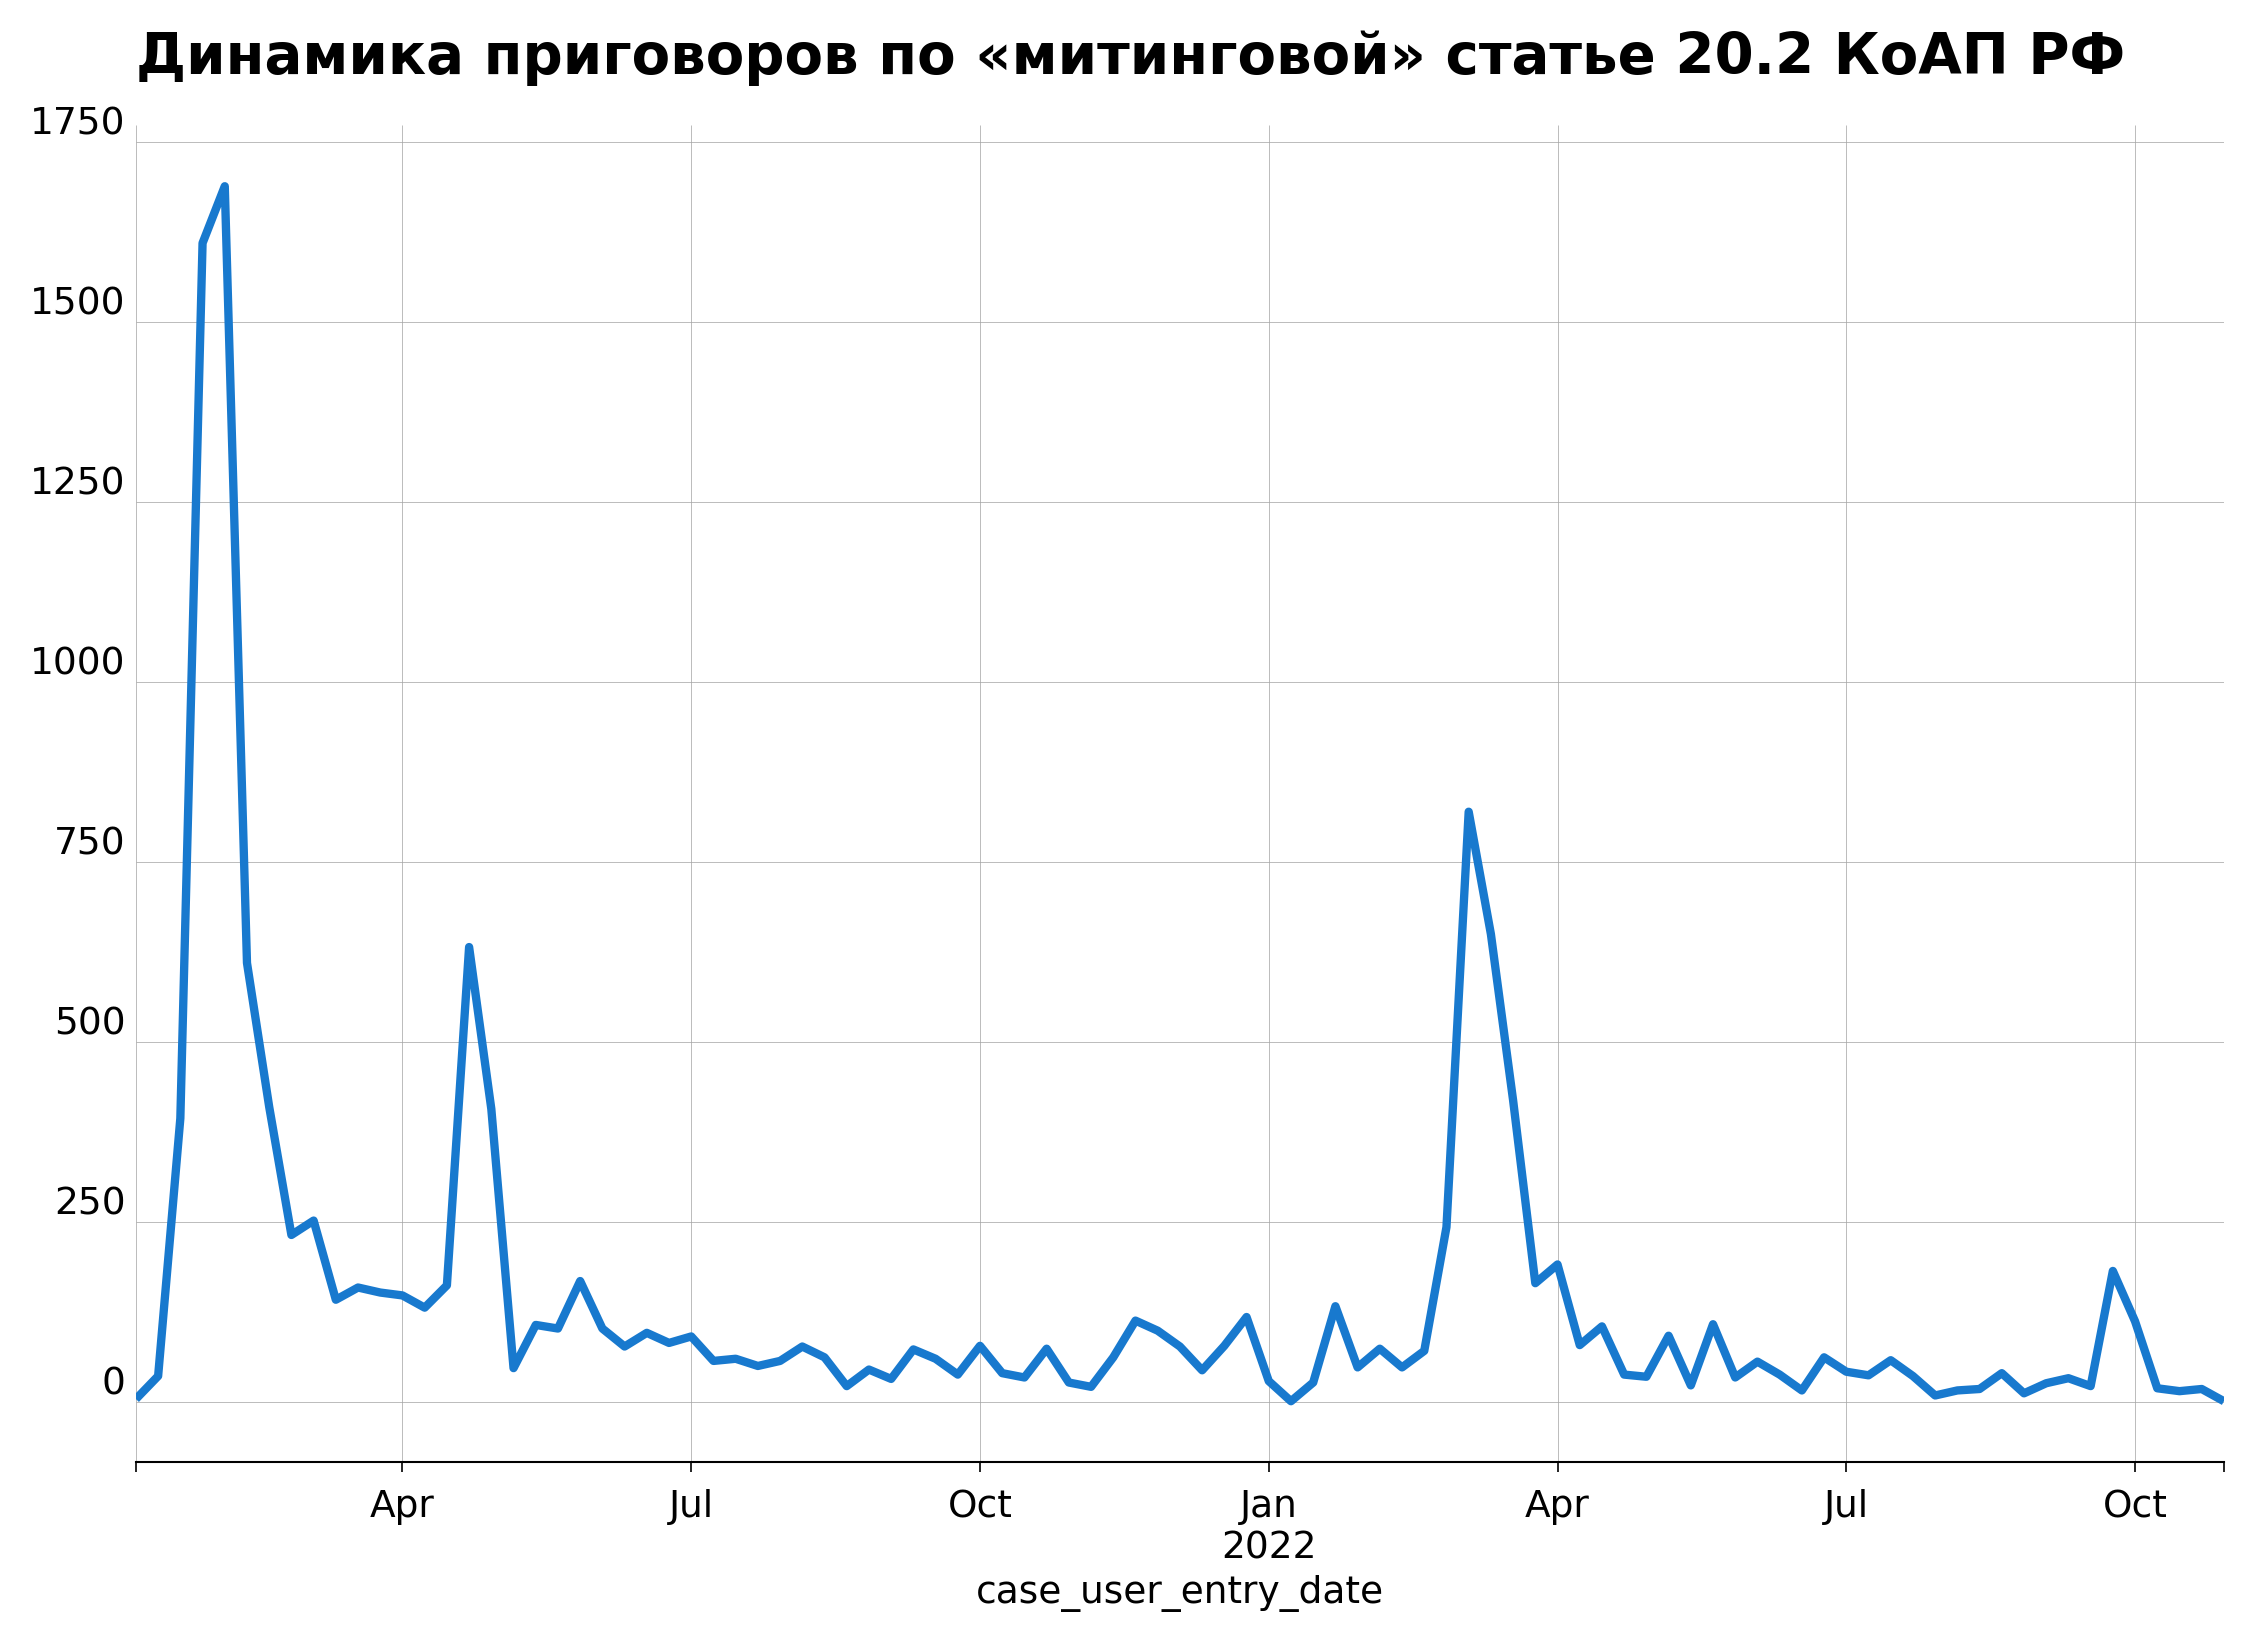

In [18]:
plot_article(
    data=df_short[df_short.article.str.contains('20.2')],
    resample_by='w',
    title='Динамика приговоров по «митинговой» статье 20.2 КоАП РФ'
)

А абсолютных цифрах дел по 20.2 КоАП в 2022 году в два раза меньше, чем в 2021 году. 

In [19]:
df_short[df_short.article.str.contains('20.2')].groupby('year').size()

year
2021    9569
2022    4272
dtype: int64

## 20.3.3 КоАП. Публичные действия, направленные на дискредитацию использования Вооруженных Сил РФ

* пик приговоров по 20.3.3 пришёлся на март 2022 года, то есть разгар антивоенных протестов
* после этого число приговоров снижалось, но всё равно оставалось стабильно высоким. Практически весь год суды выносили 100+ приговоров в неделю. 
* наиболее низкое значение приговорам было в сентябре, прямо перед началом мобилизации в России. После неё же был и новый всплеск приговоров по делам за дискредитацию ВС РФ. 

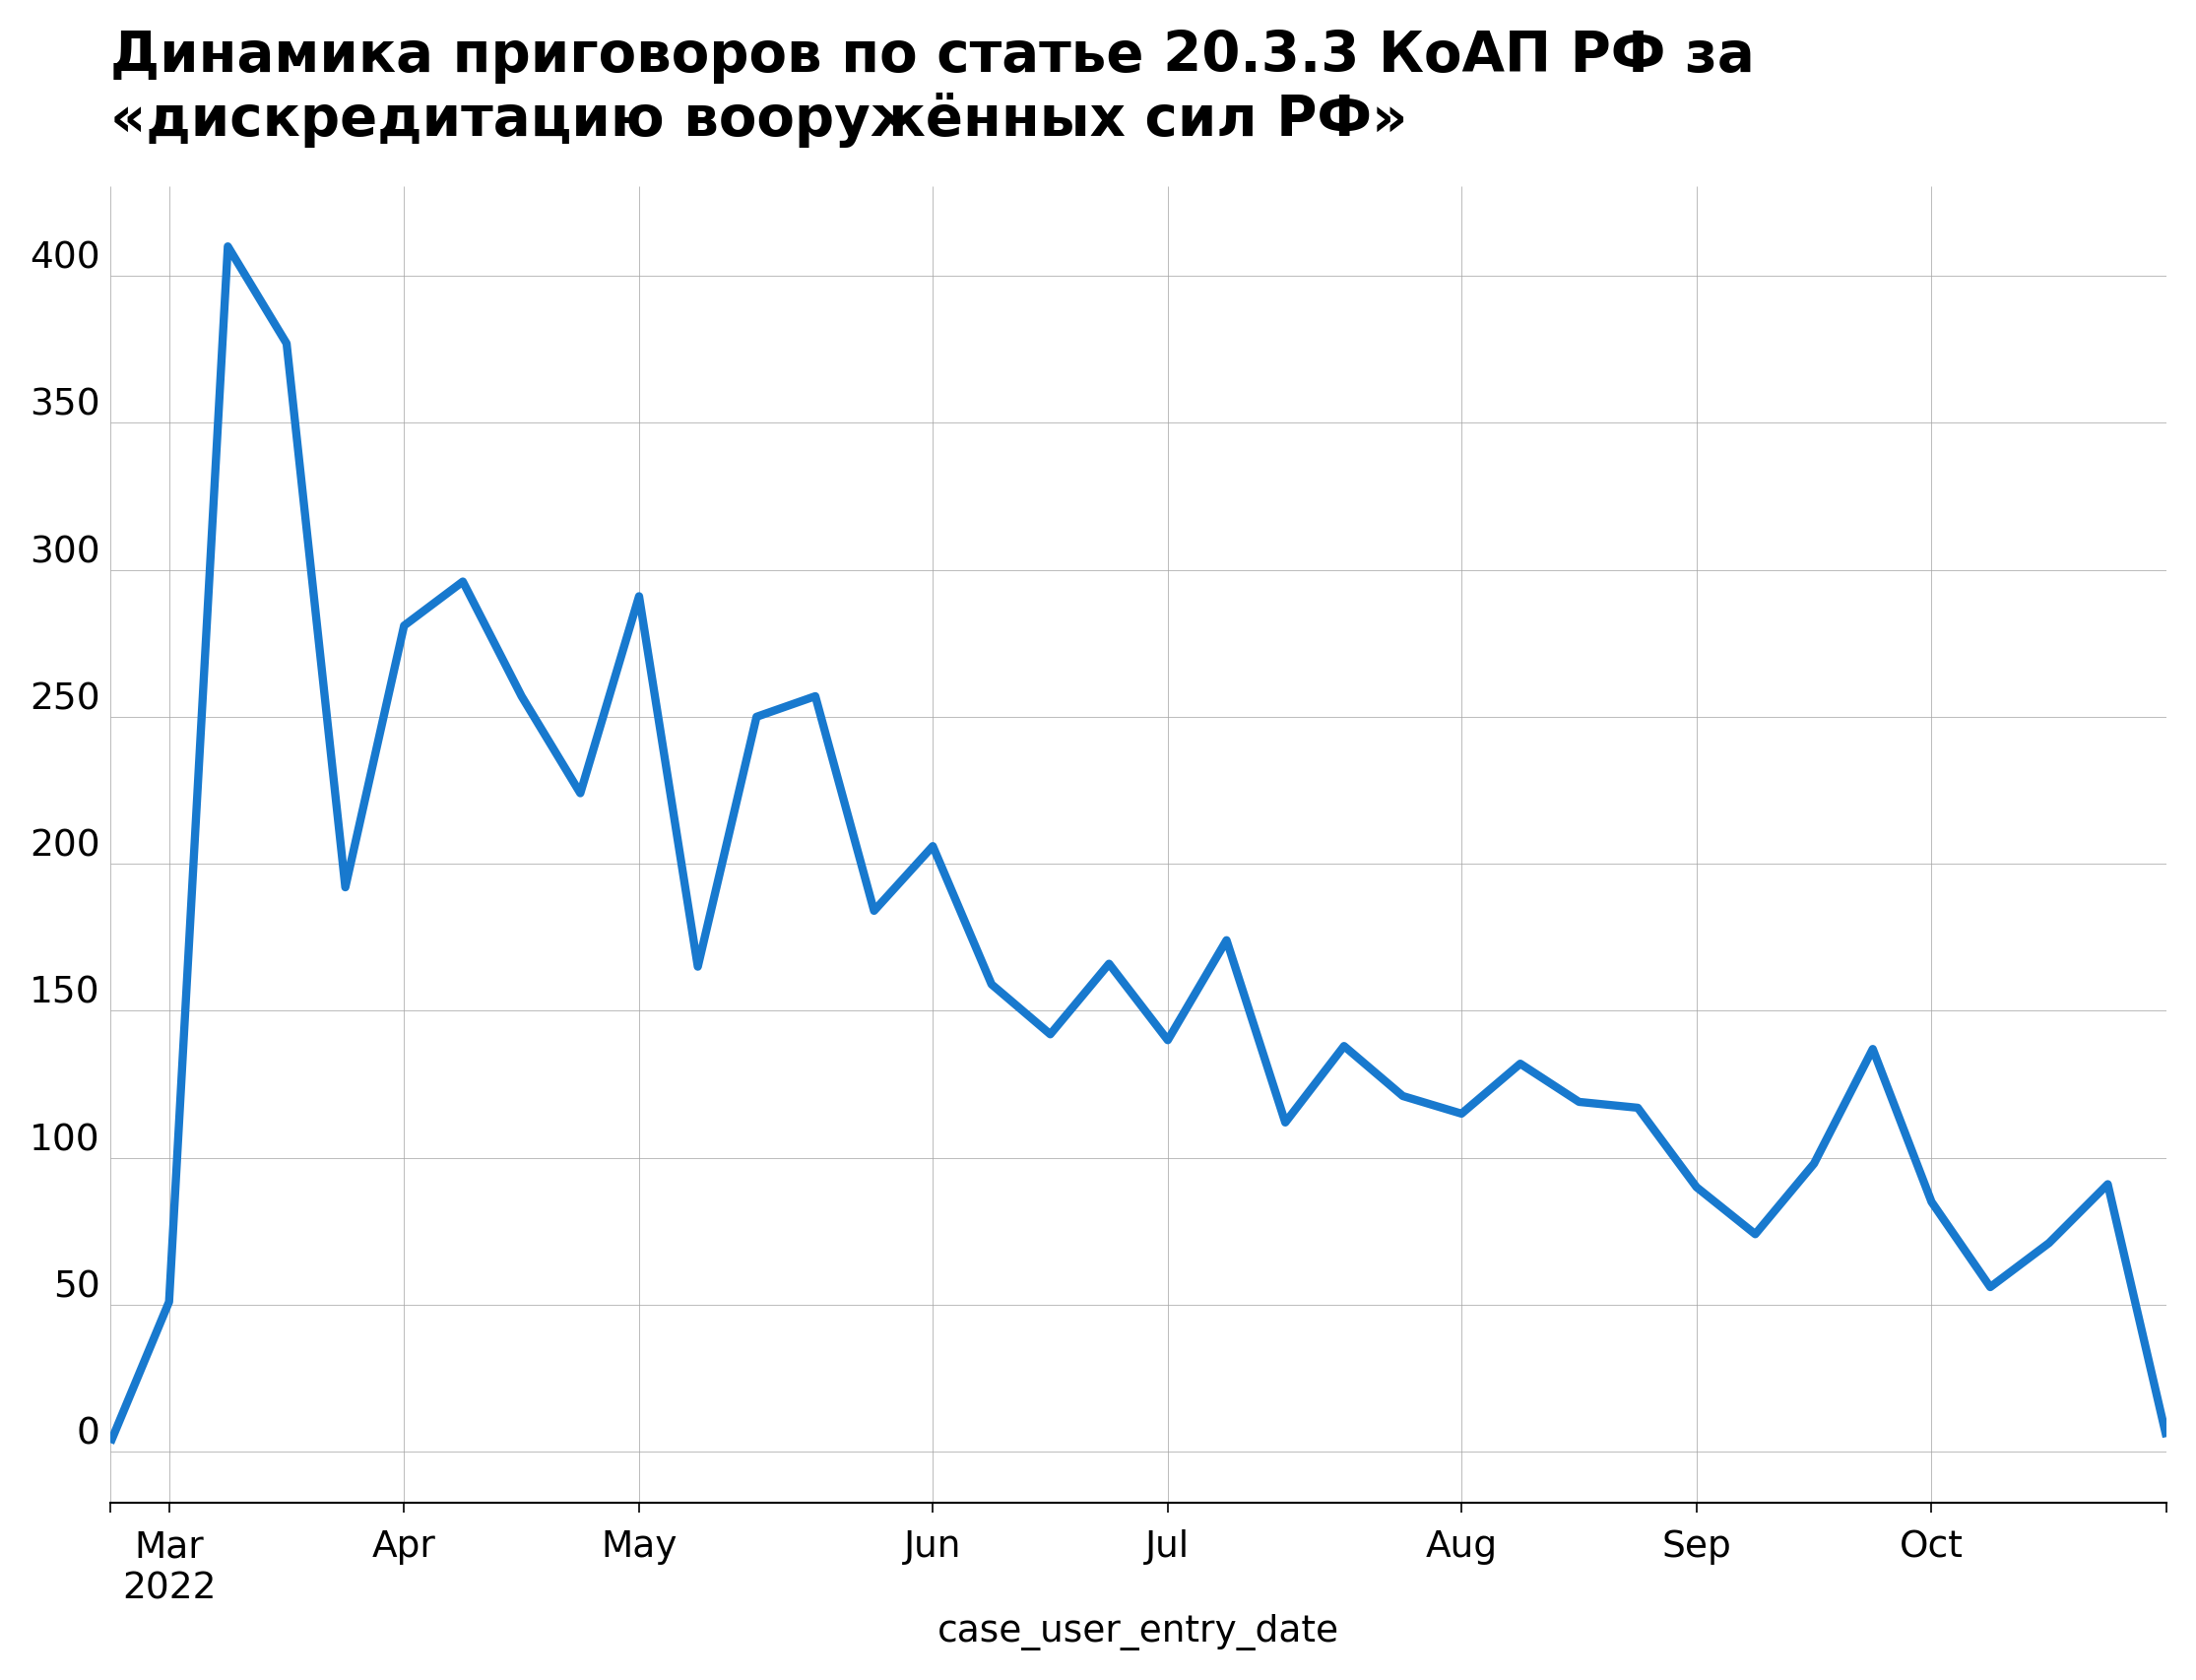

In [20]:
plot_article(
    data=df_short[df_short.article.str.contains('20.3.3')],
    resample_by='w',
    title='Динамика приговоров по статье 20.3.3 КоАП РФ за \n«дискредитацию вооружённых сил РФ»'
)

Как и писал выше в 2021 году после окончания уличных акций суды практически перестали выносить приговоры. В 2022 же году после окончания уличных протестов преследования активистов продолжилось по 20.3.3  КоАП. Скорее всего это приговоры за высказывания в соцсетях. То есть новая статья оказалась весьма удобным инструментом для постоянного давления протих граждан выступающих против войны. 

Вообще правоохранительные органы достаточно быстро освоили новую статью -- 5786 приговора всего за 8 месяцев. 

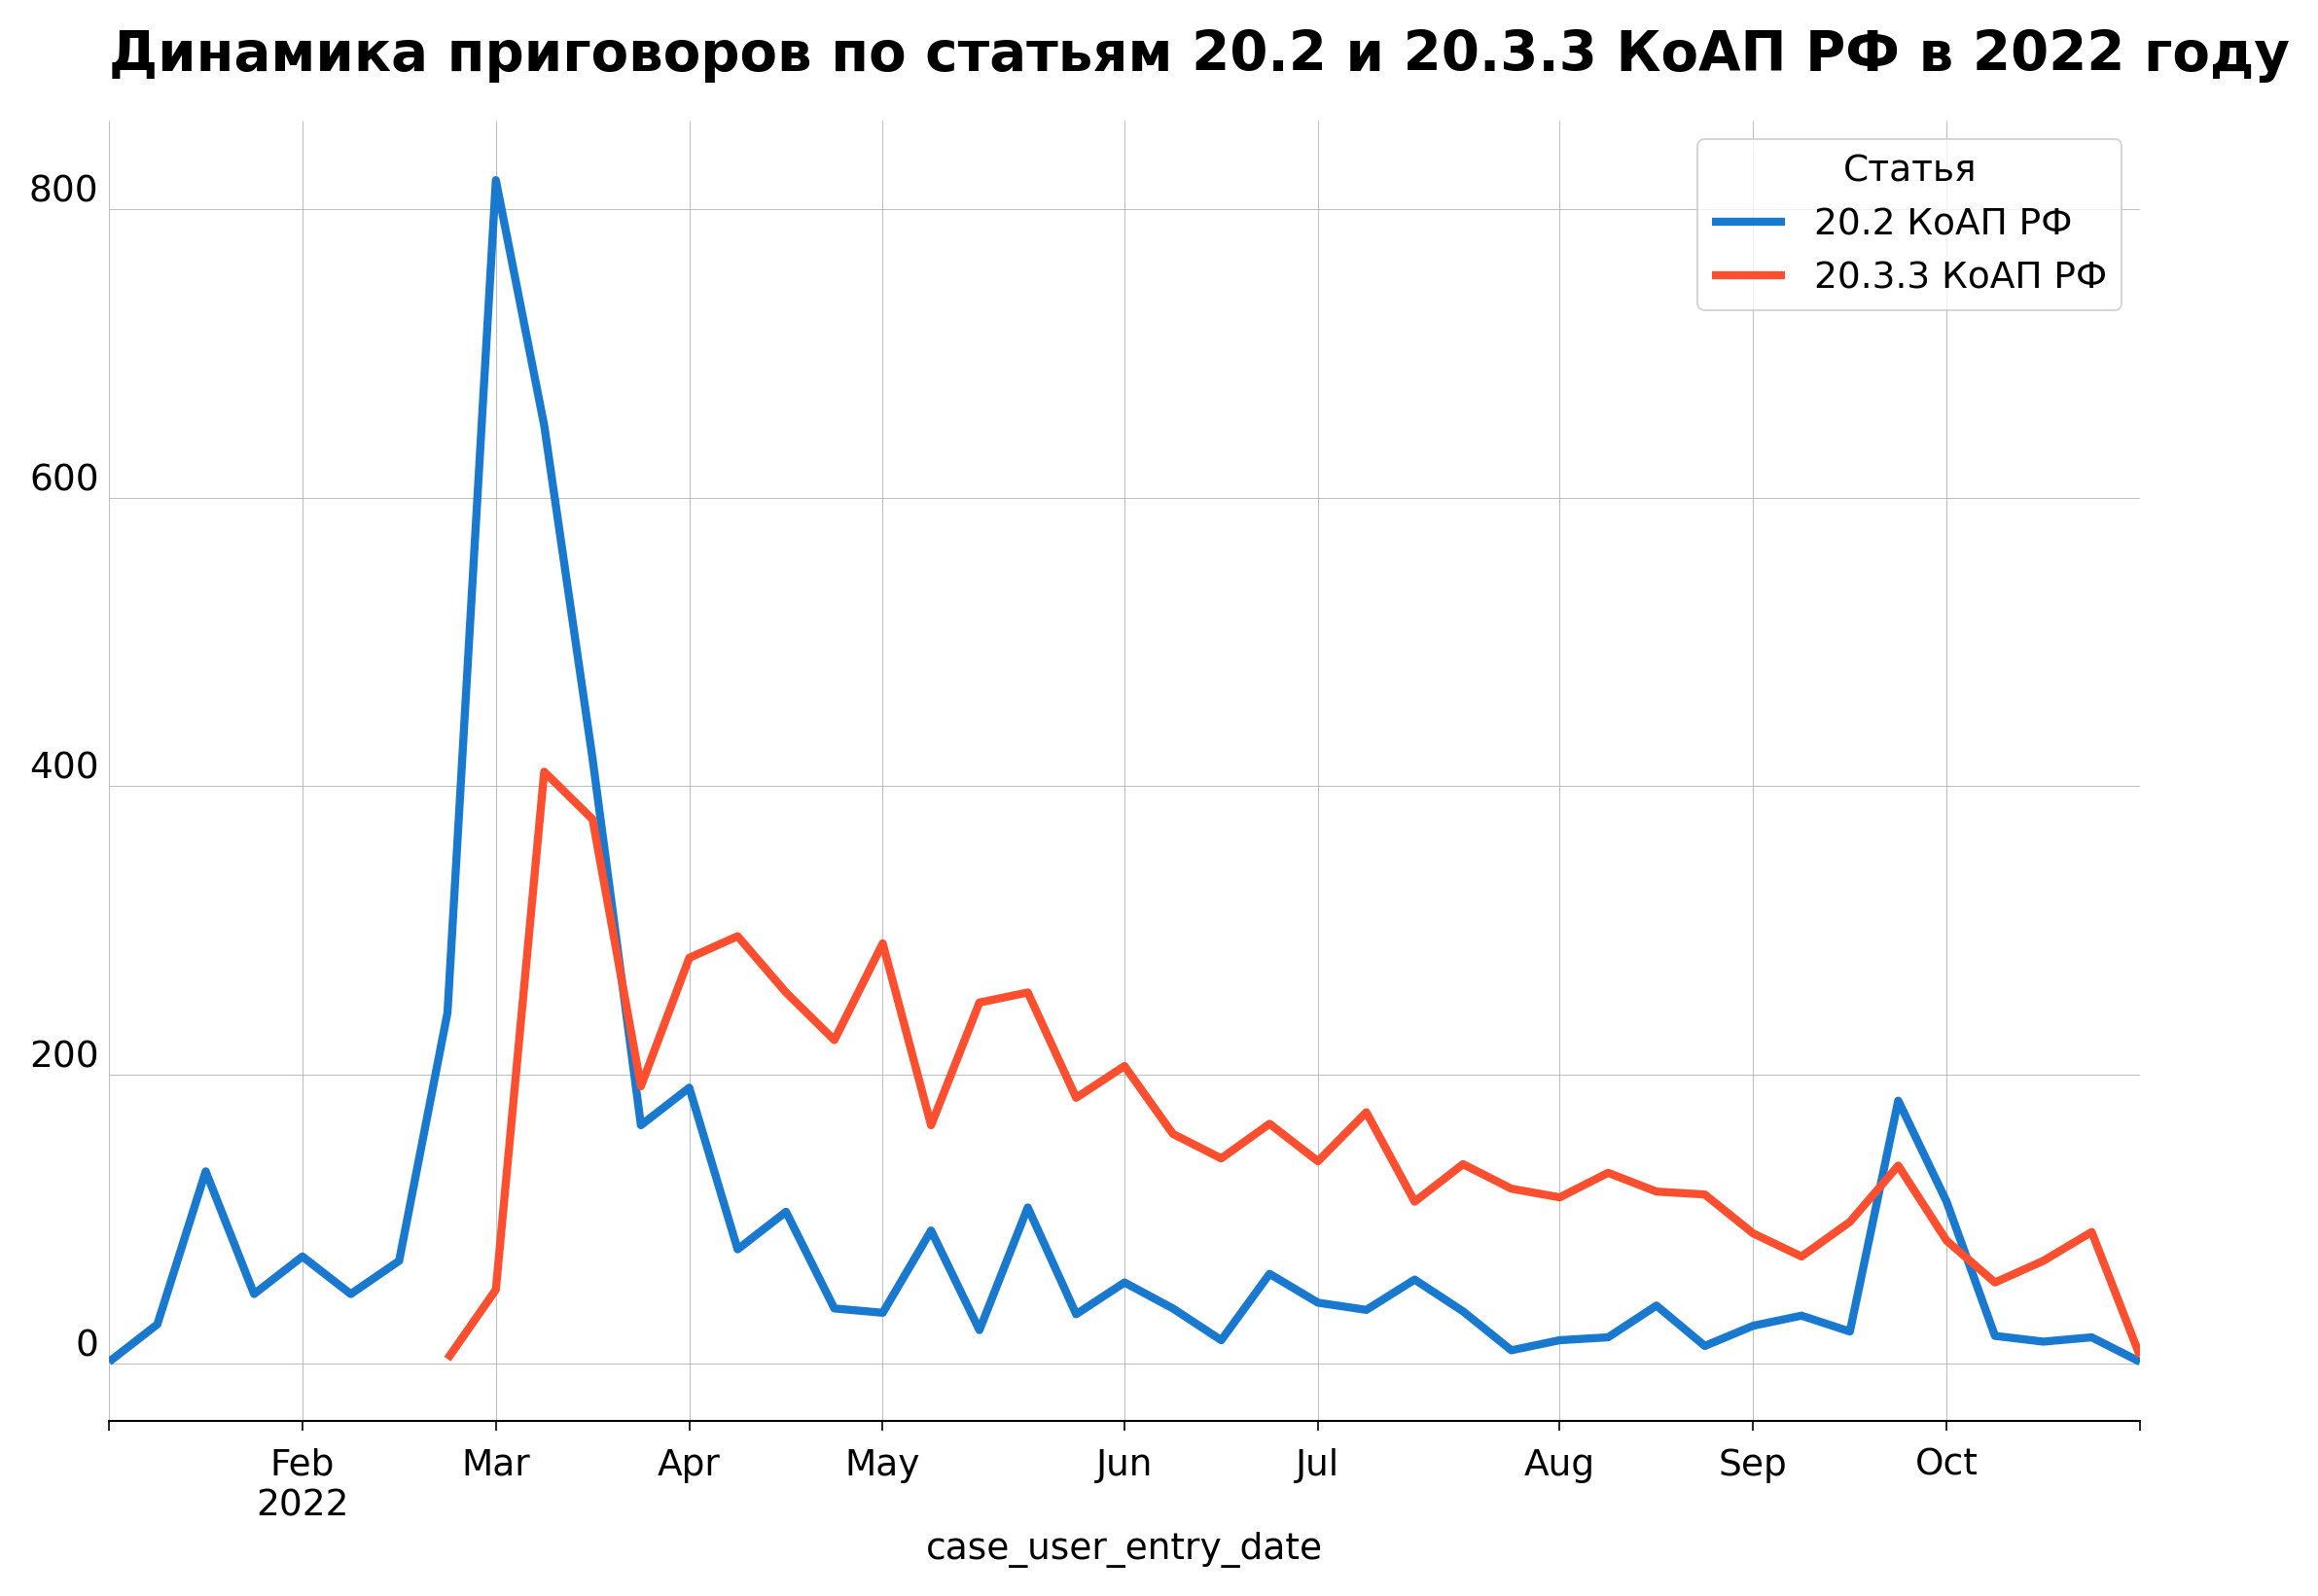

In [21]:
plot_article(
    data=df_short[(df_short.year == 2022) & (df_short.article.str.contains('20.2'))],
    resample_by='w',
)

plot_article(
    data=df_short[(df_short.year == 2022) & (df_short.article.str.contains('20.3.3'))],
    resample_by='w',
)

plt.title('Динамика приговоров по статьям 20.2 и 20.3.3 КоАП РФ в 2022 году')
plt.legend(title='Статья', labels=['20.2 КоАП РФ', '20.3.3 КоАП РФ']);

## 20.29 КоАП. Производство и распространение экстремистских материалов

Всплеск приговоров по 20.29 тоже произошёл в разгар антивоенных протестов. Но после этого кол-во приговоров сильно упало, и осенью после объявления мобилизации это число уже никак не изменилось

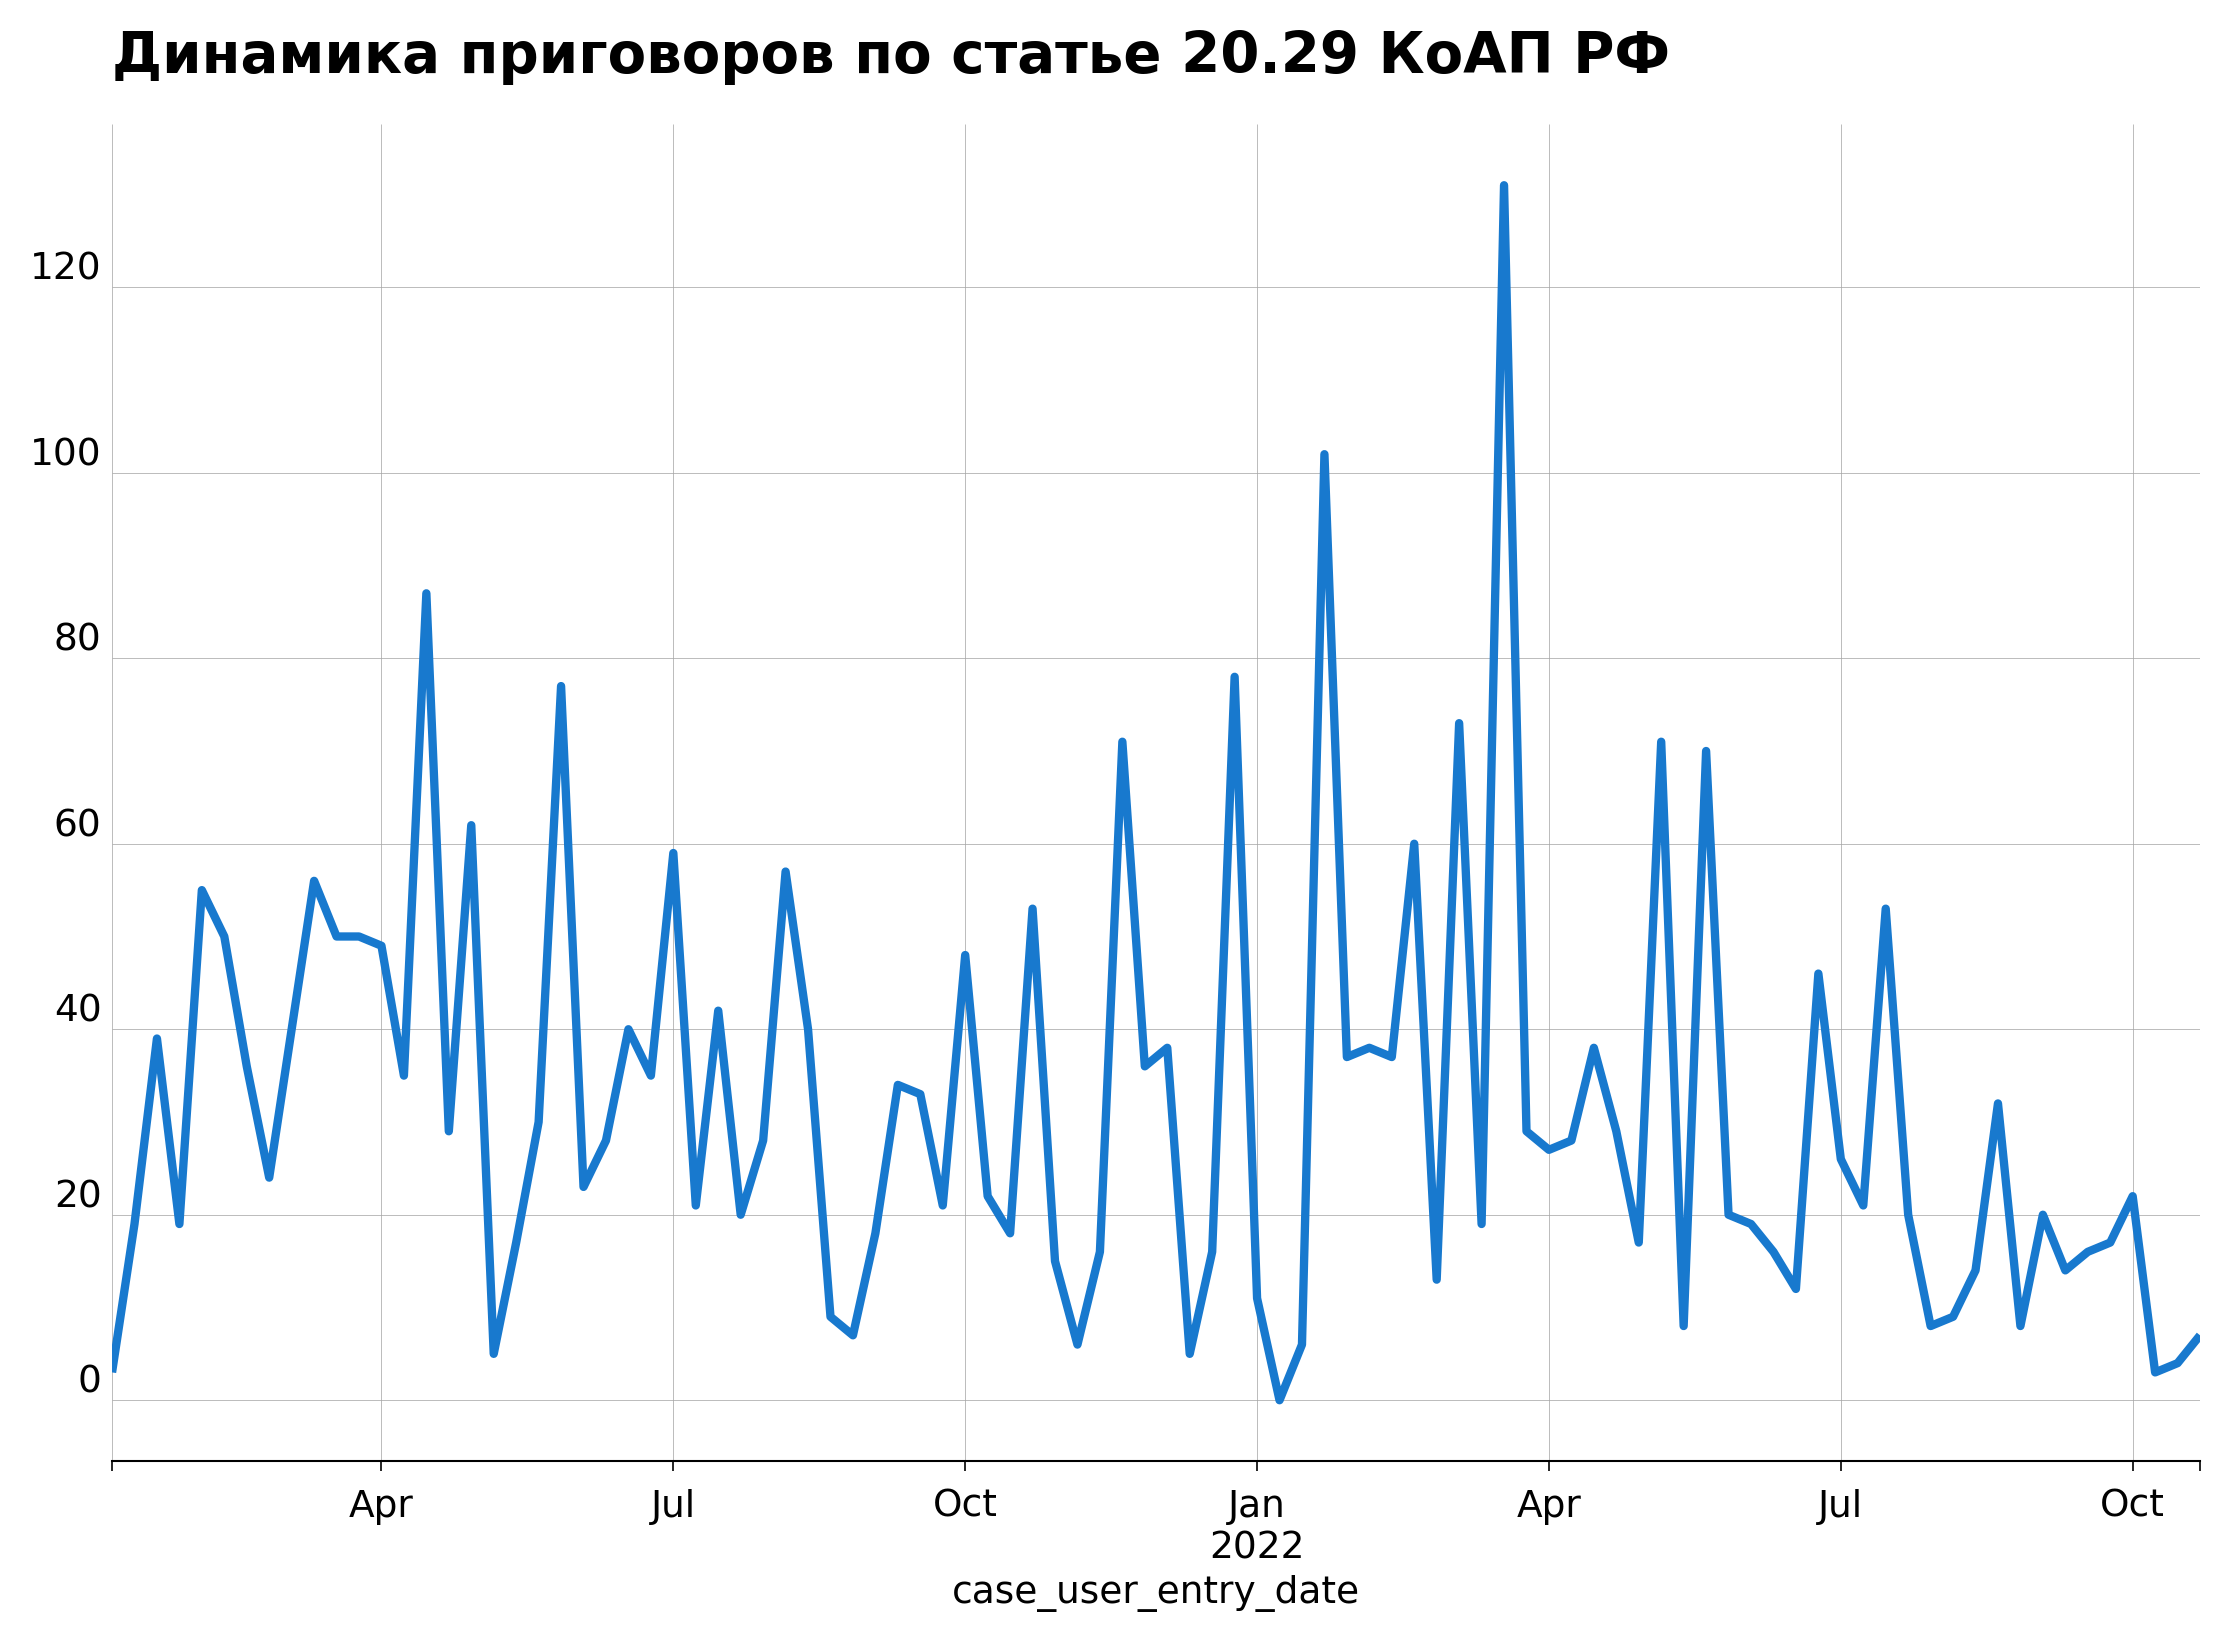

In [22]:
plot_article(
    data=df_short[df_short.article.str.contains('20.29')],
    resample_by='w',
    title='Динамика приговоров по статье 20.29 КоАП РФ'
)

## Уголовные дела

Отдельно про каждую уголовную статью писать особо нечего. Тут главный вывод - уголовных дел в 2022 году стало больше, но на ГАС Правосудии это будет видно позже, когда завершится производство по многим уголовным делам. Но даже сейчас цифры приговоров между 2021 и 2022 годом отличаются на 350 дел. 

In [23]:
df_short[df_short.case_user_doc_number.str.contains('Уголовное')].groupby('year').size()

year
2021    2504
2022    2165
dtype: int64

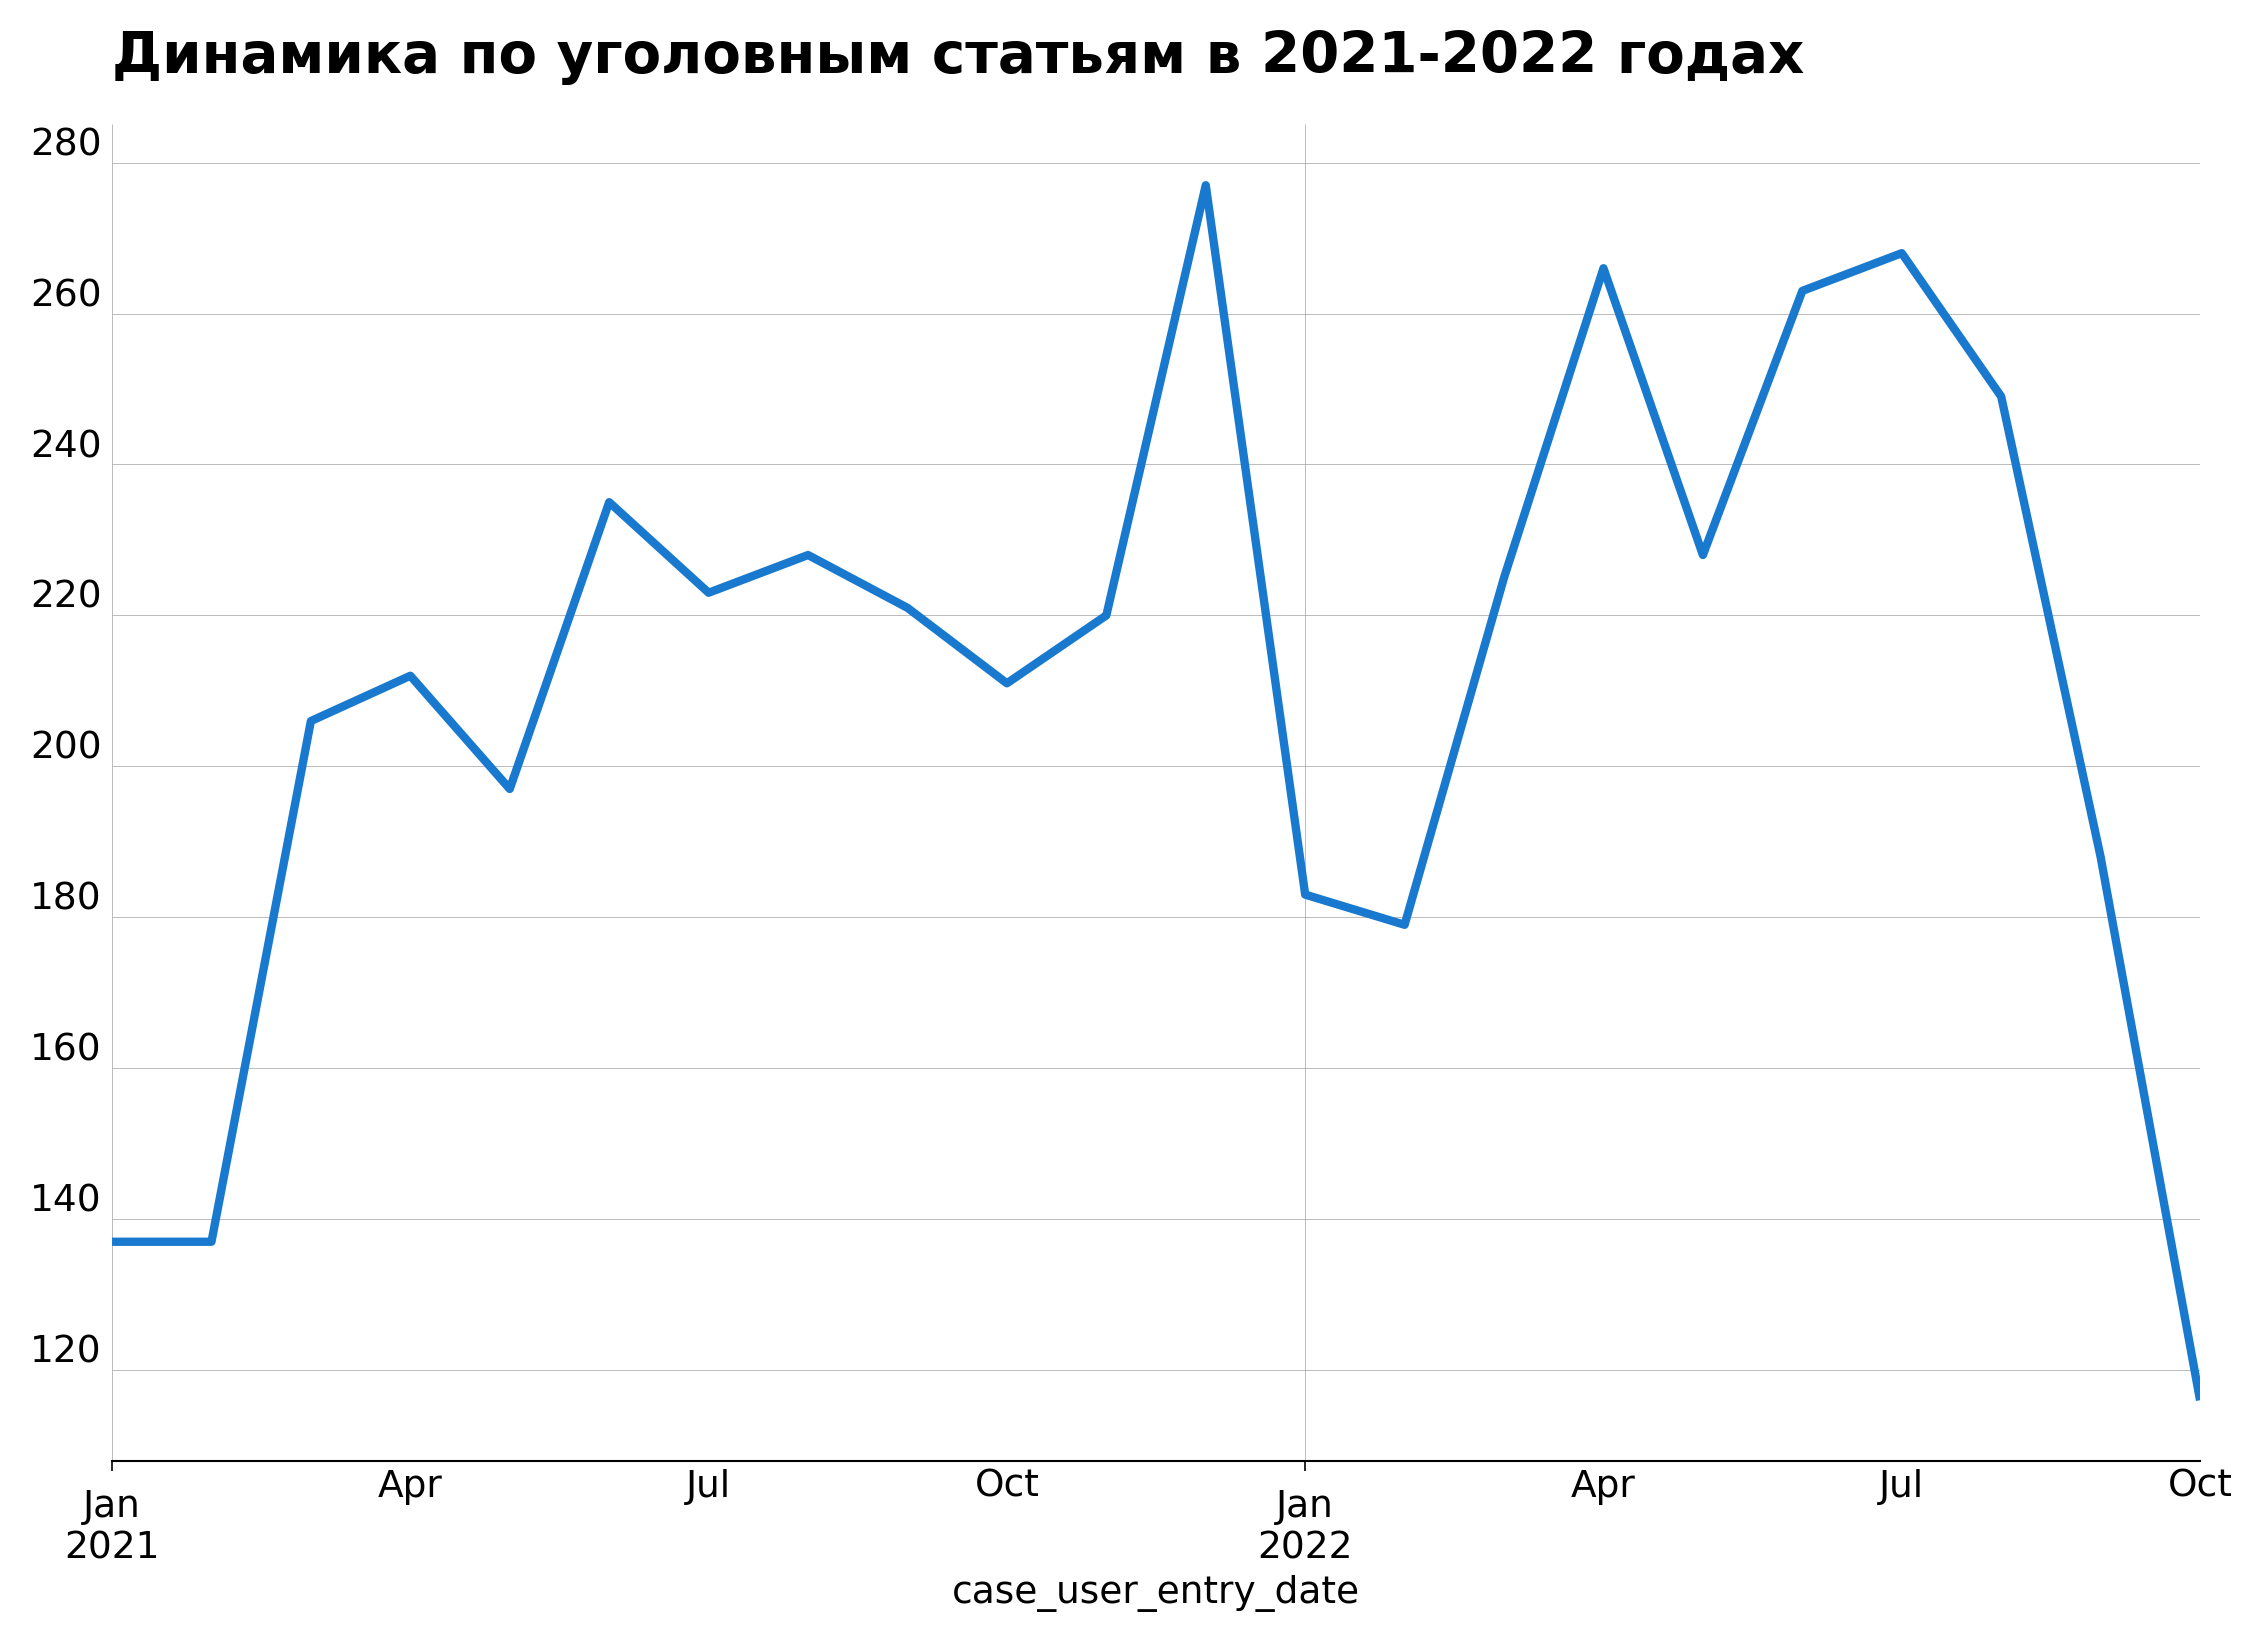

In [24]:
plot_article(
    data=df_short[df_short.case_user_doc_number.str.contains('Уголовное')],
    resample_by='m',
    title='Динамика по уголовным статьям в 2021-2022 годах'
)

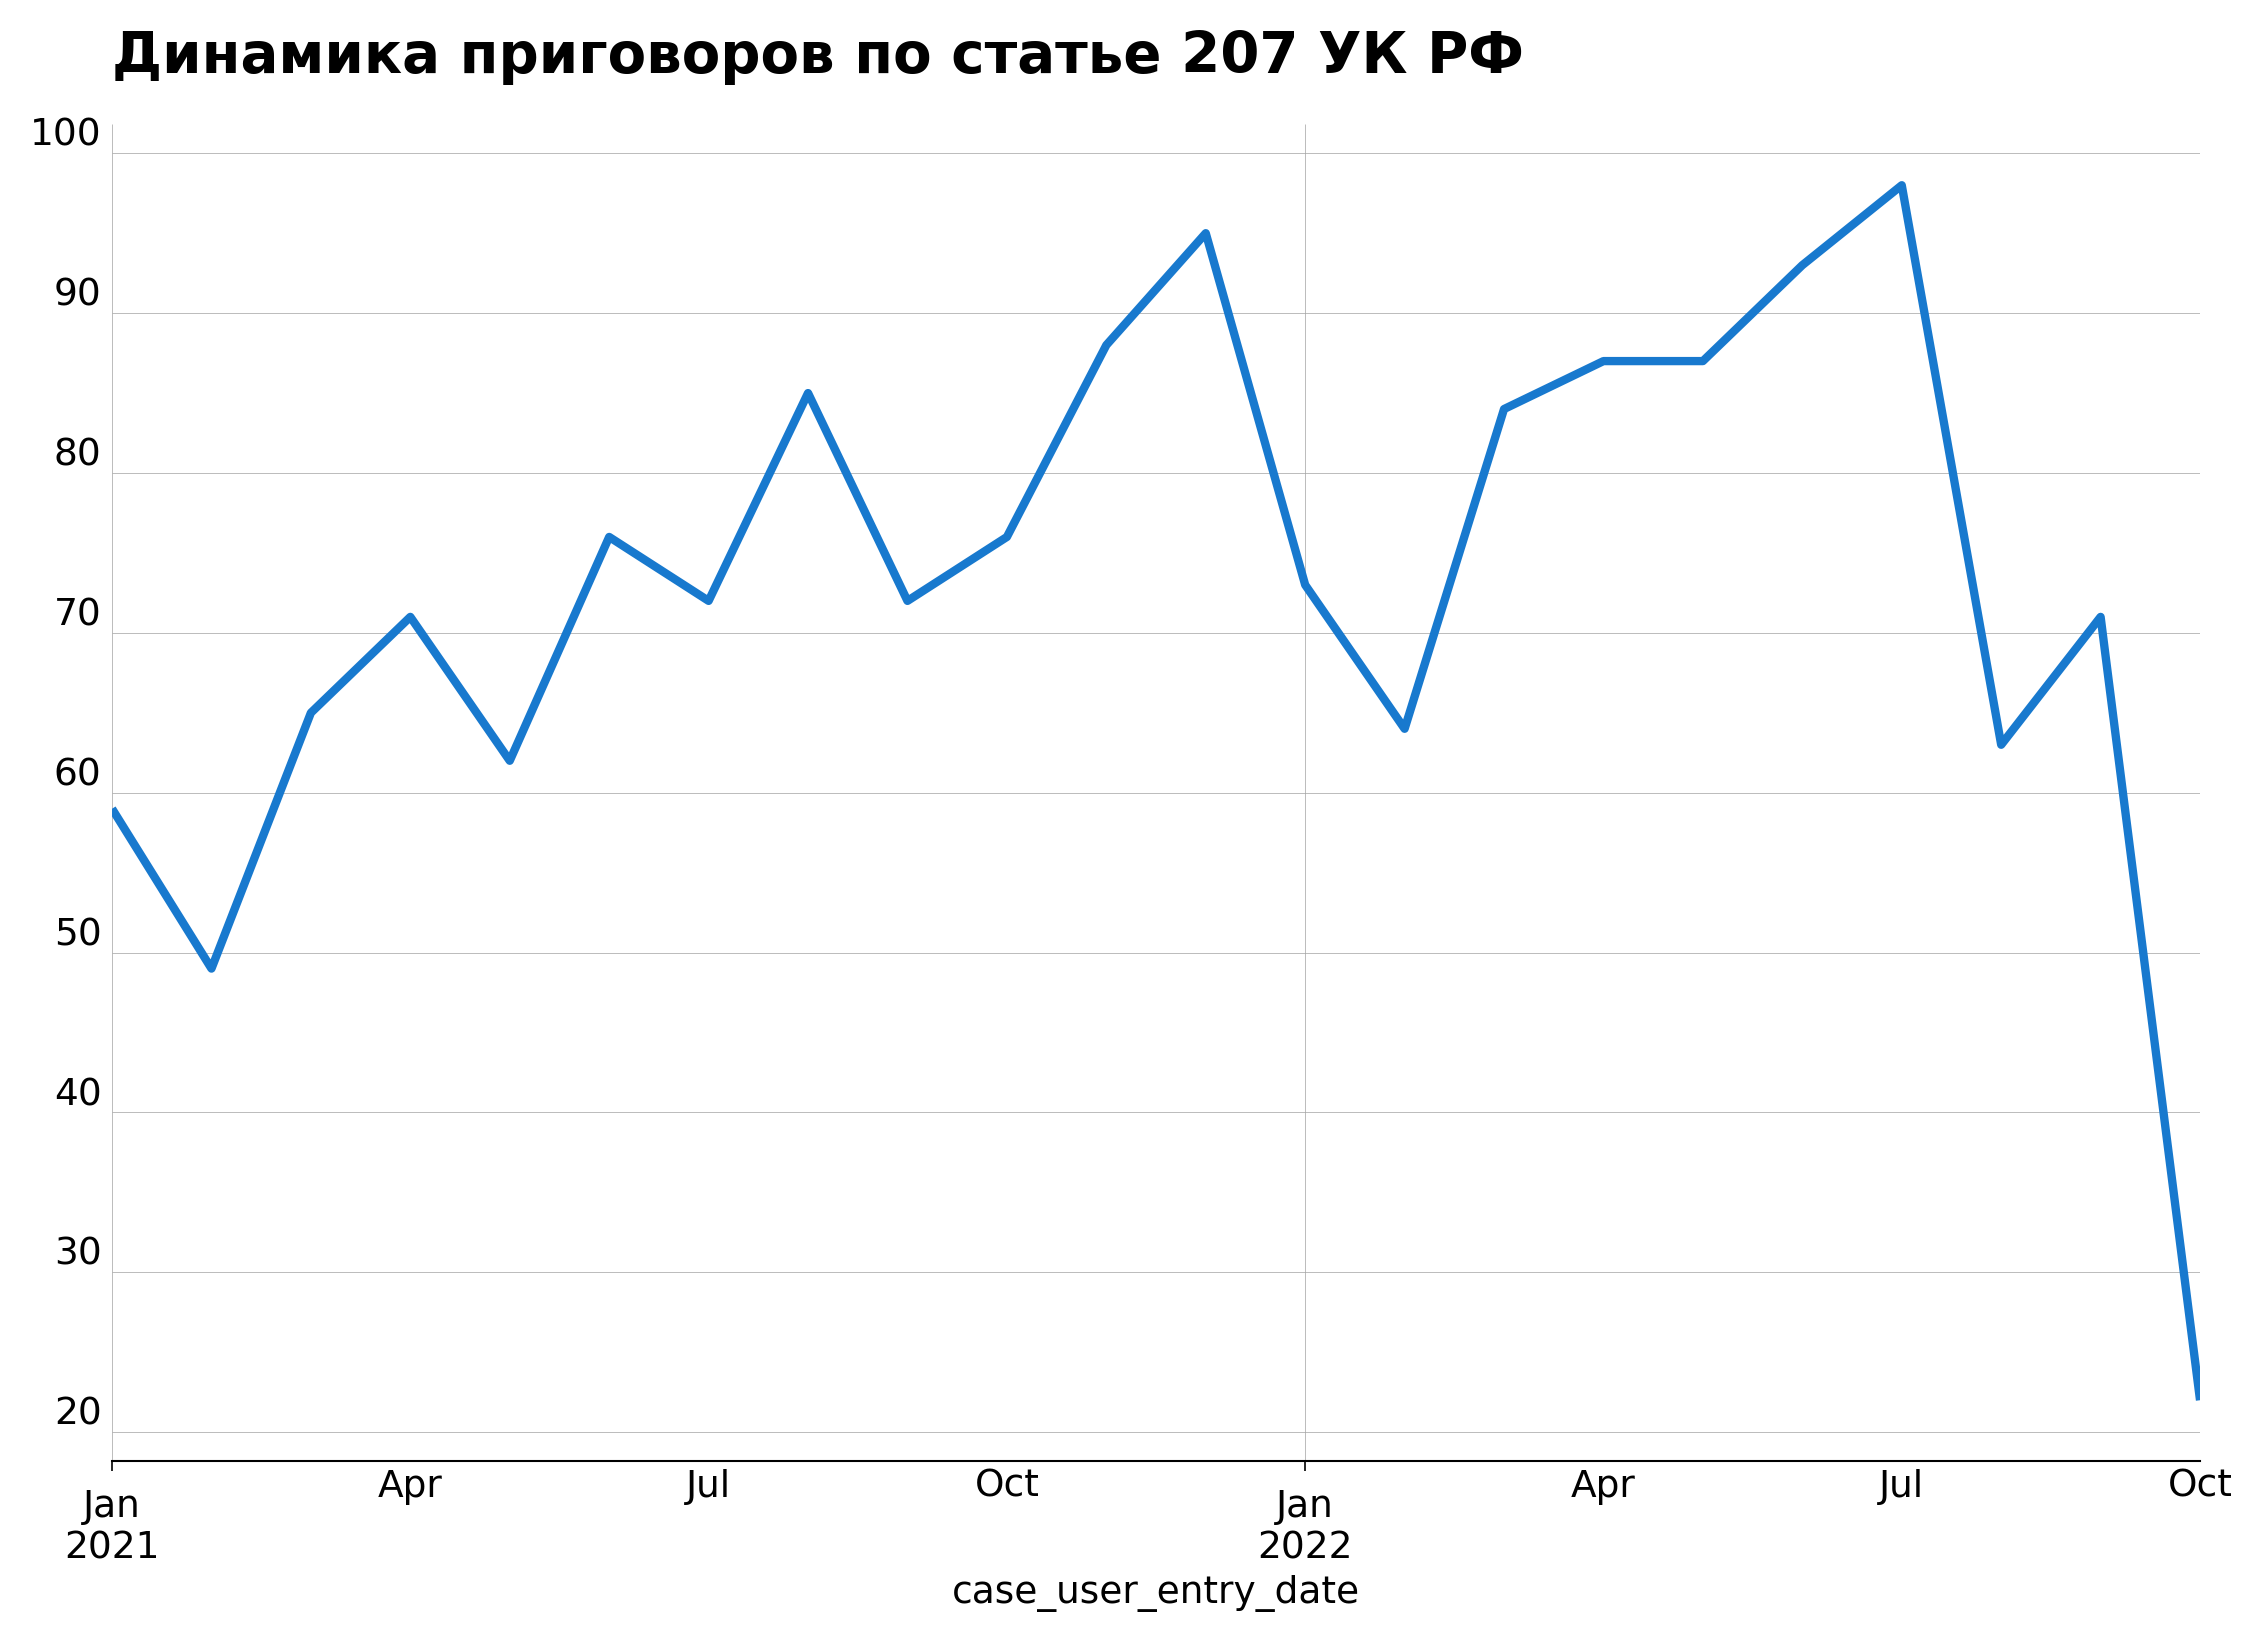

In [25]:
plot_article(
    data=df_short[df_short.article.str.contains('207')],
    resample_by='m',
    title='Динамика приговоров по статье 207 УК РФ'
)

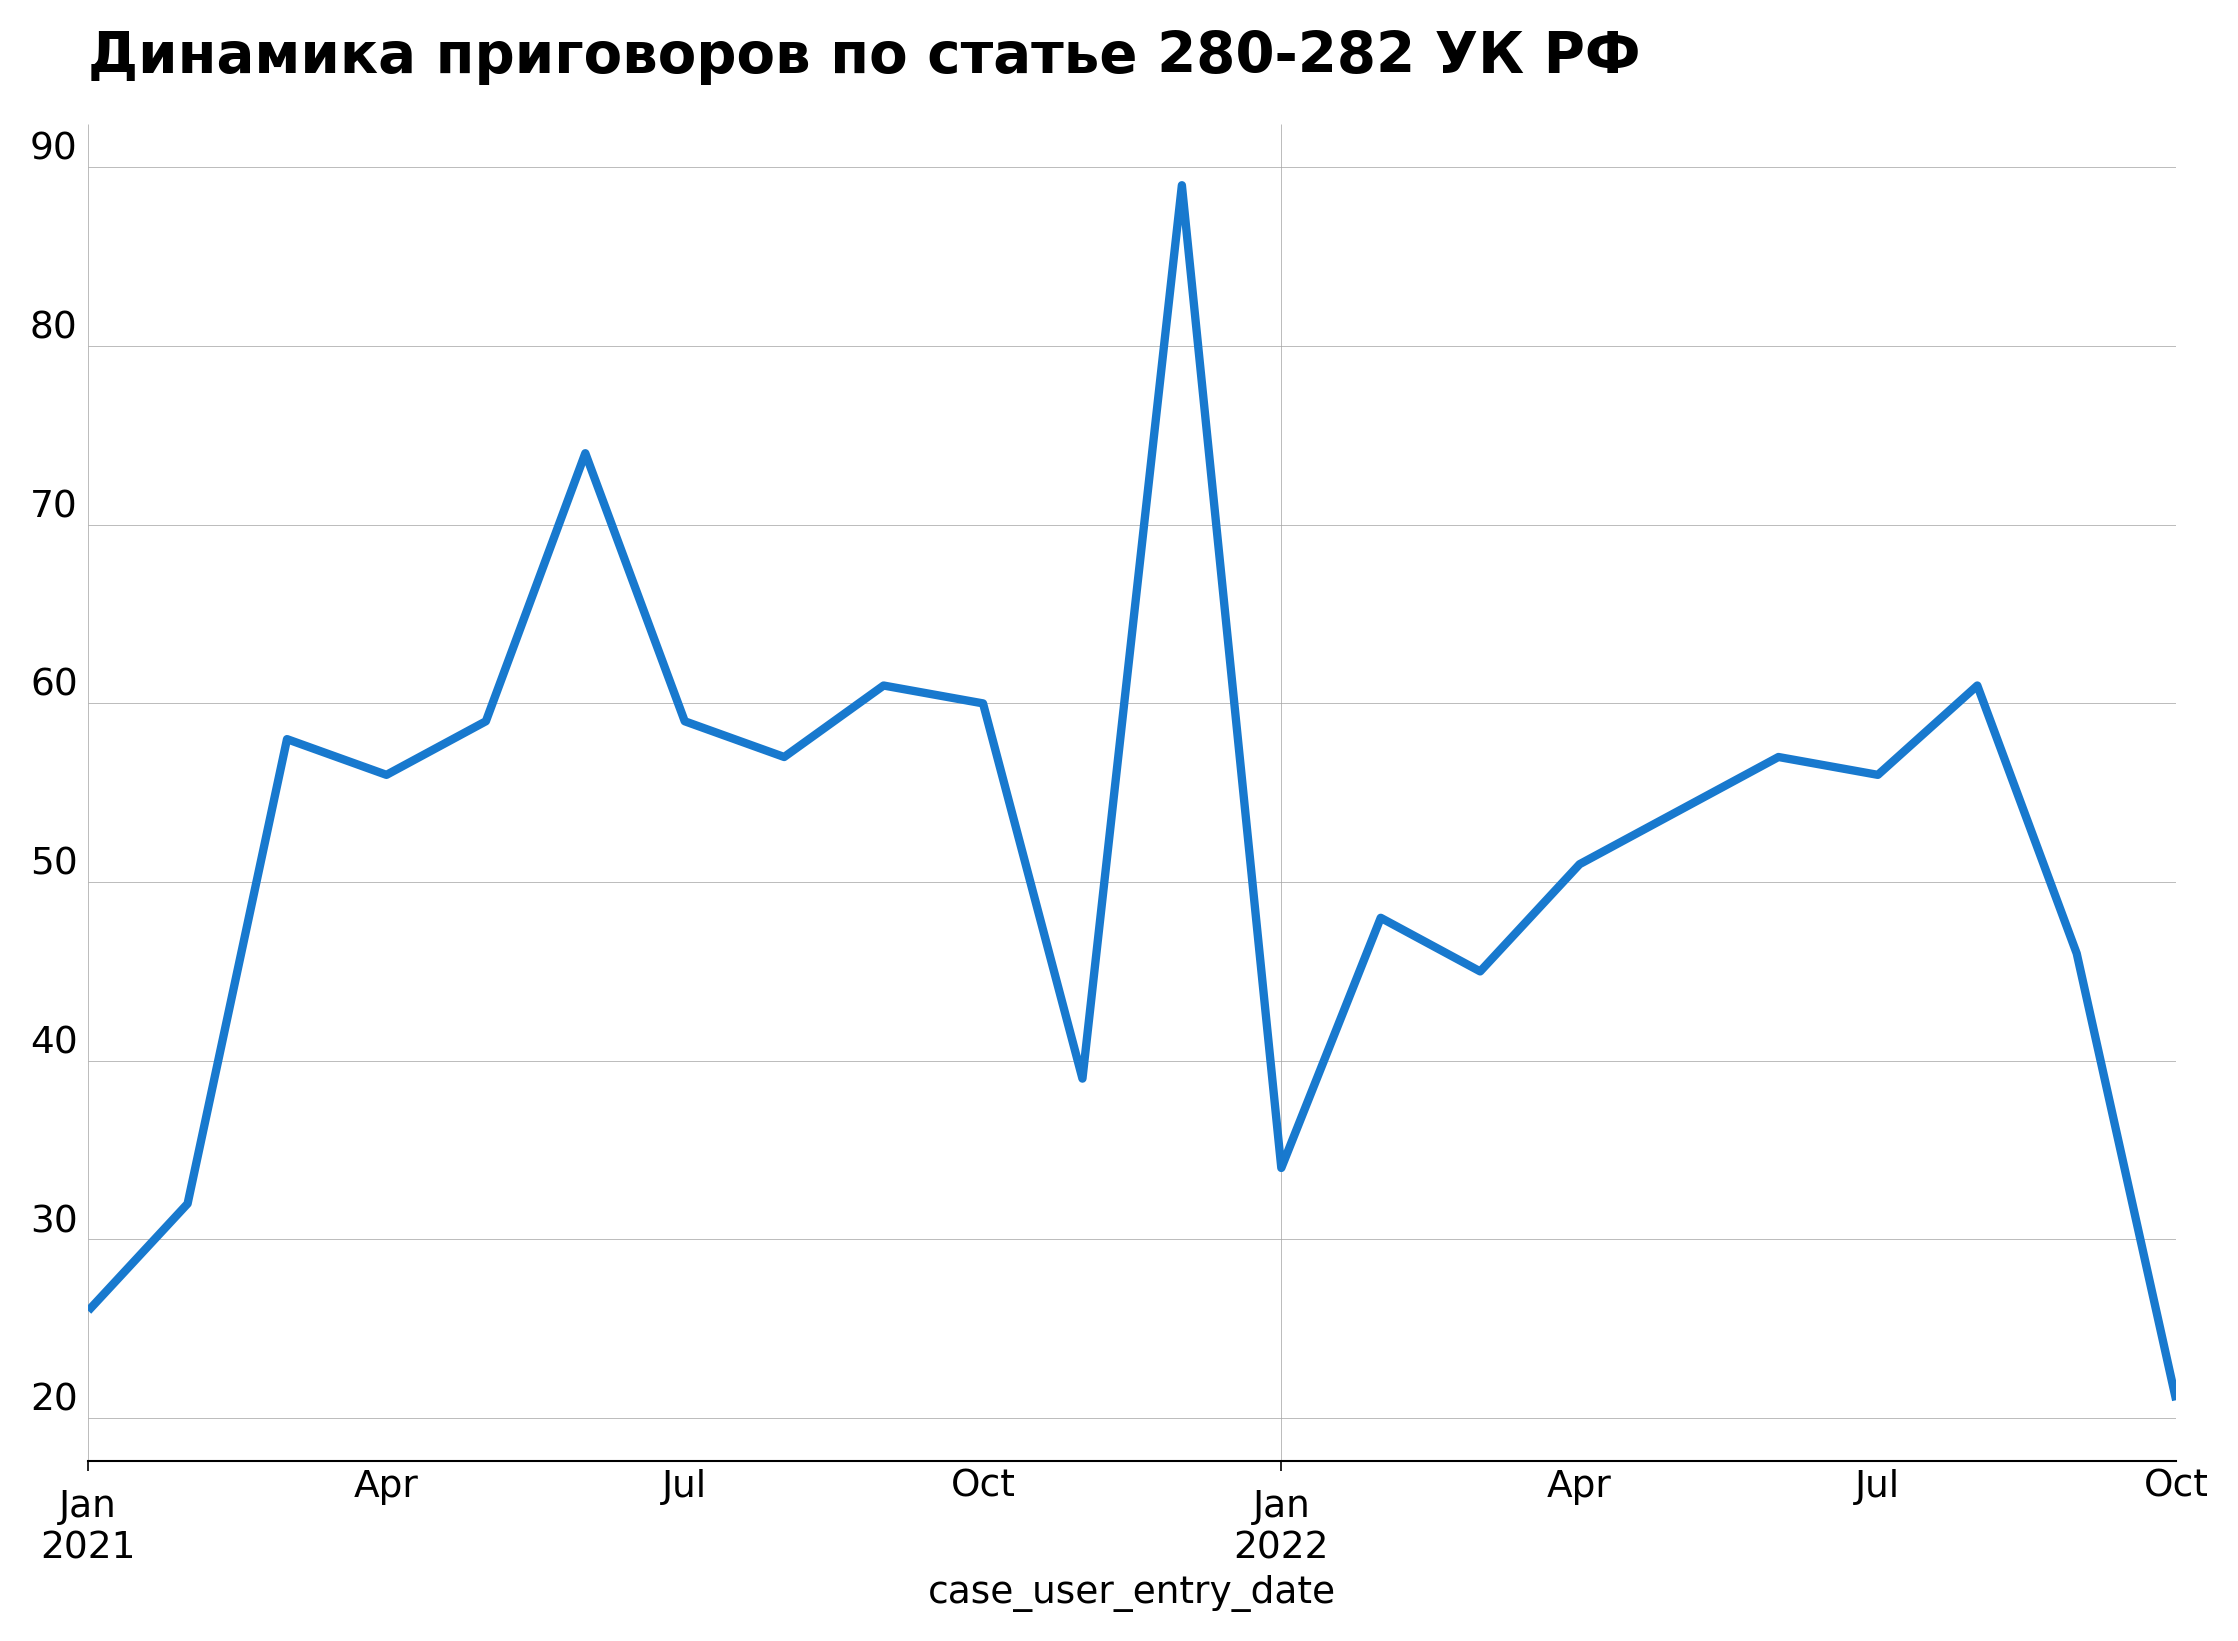

In [36]:
plot_article(
    data=df_short[df_short.article.str.contains('280') | df_short.article.str.contains('282')],
    resample_by='m',
    title='Динамика приговоров по статье 280-282 УК РФ'
)

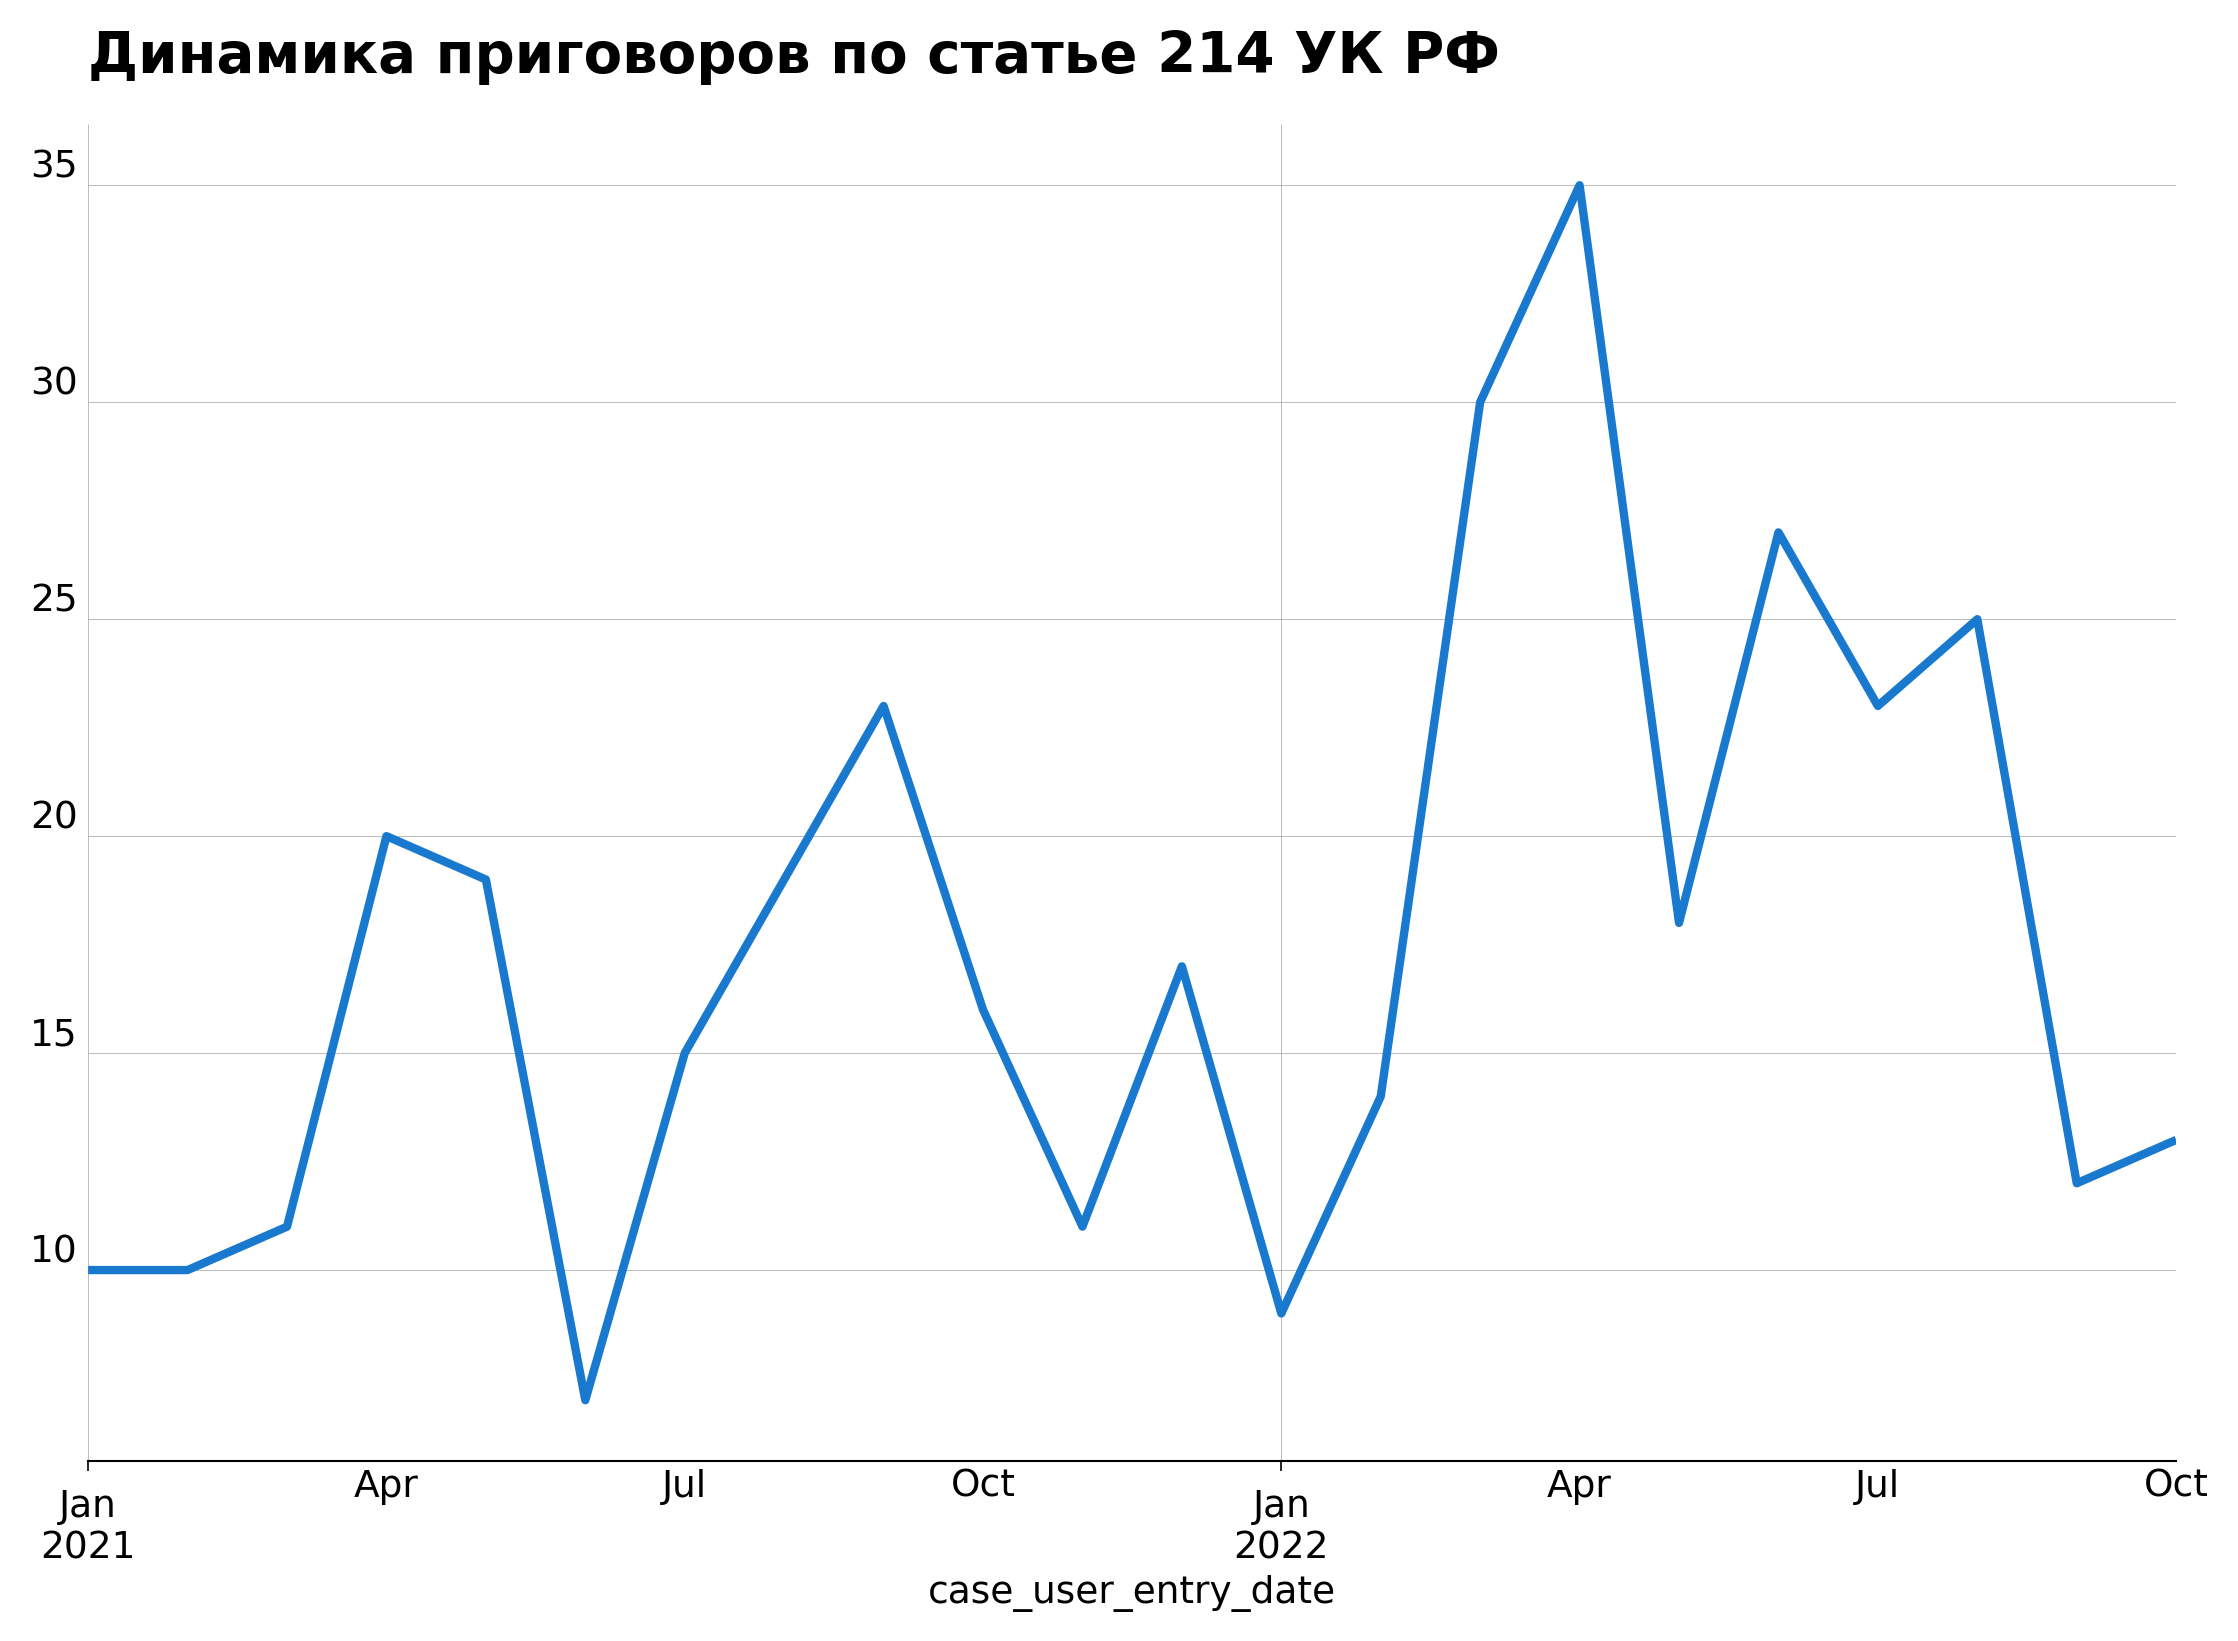

In [38]:
plot_article(
    data=df_short[df_short.article.str.contains('214')],
    resample_by='m',
    title='Динамика приговоров по статье 214 УК РФ'
)

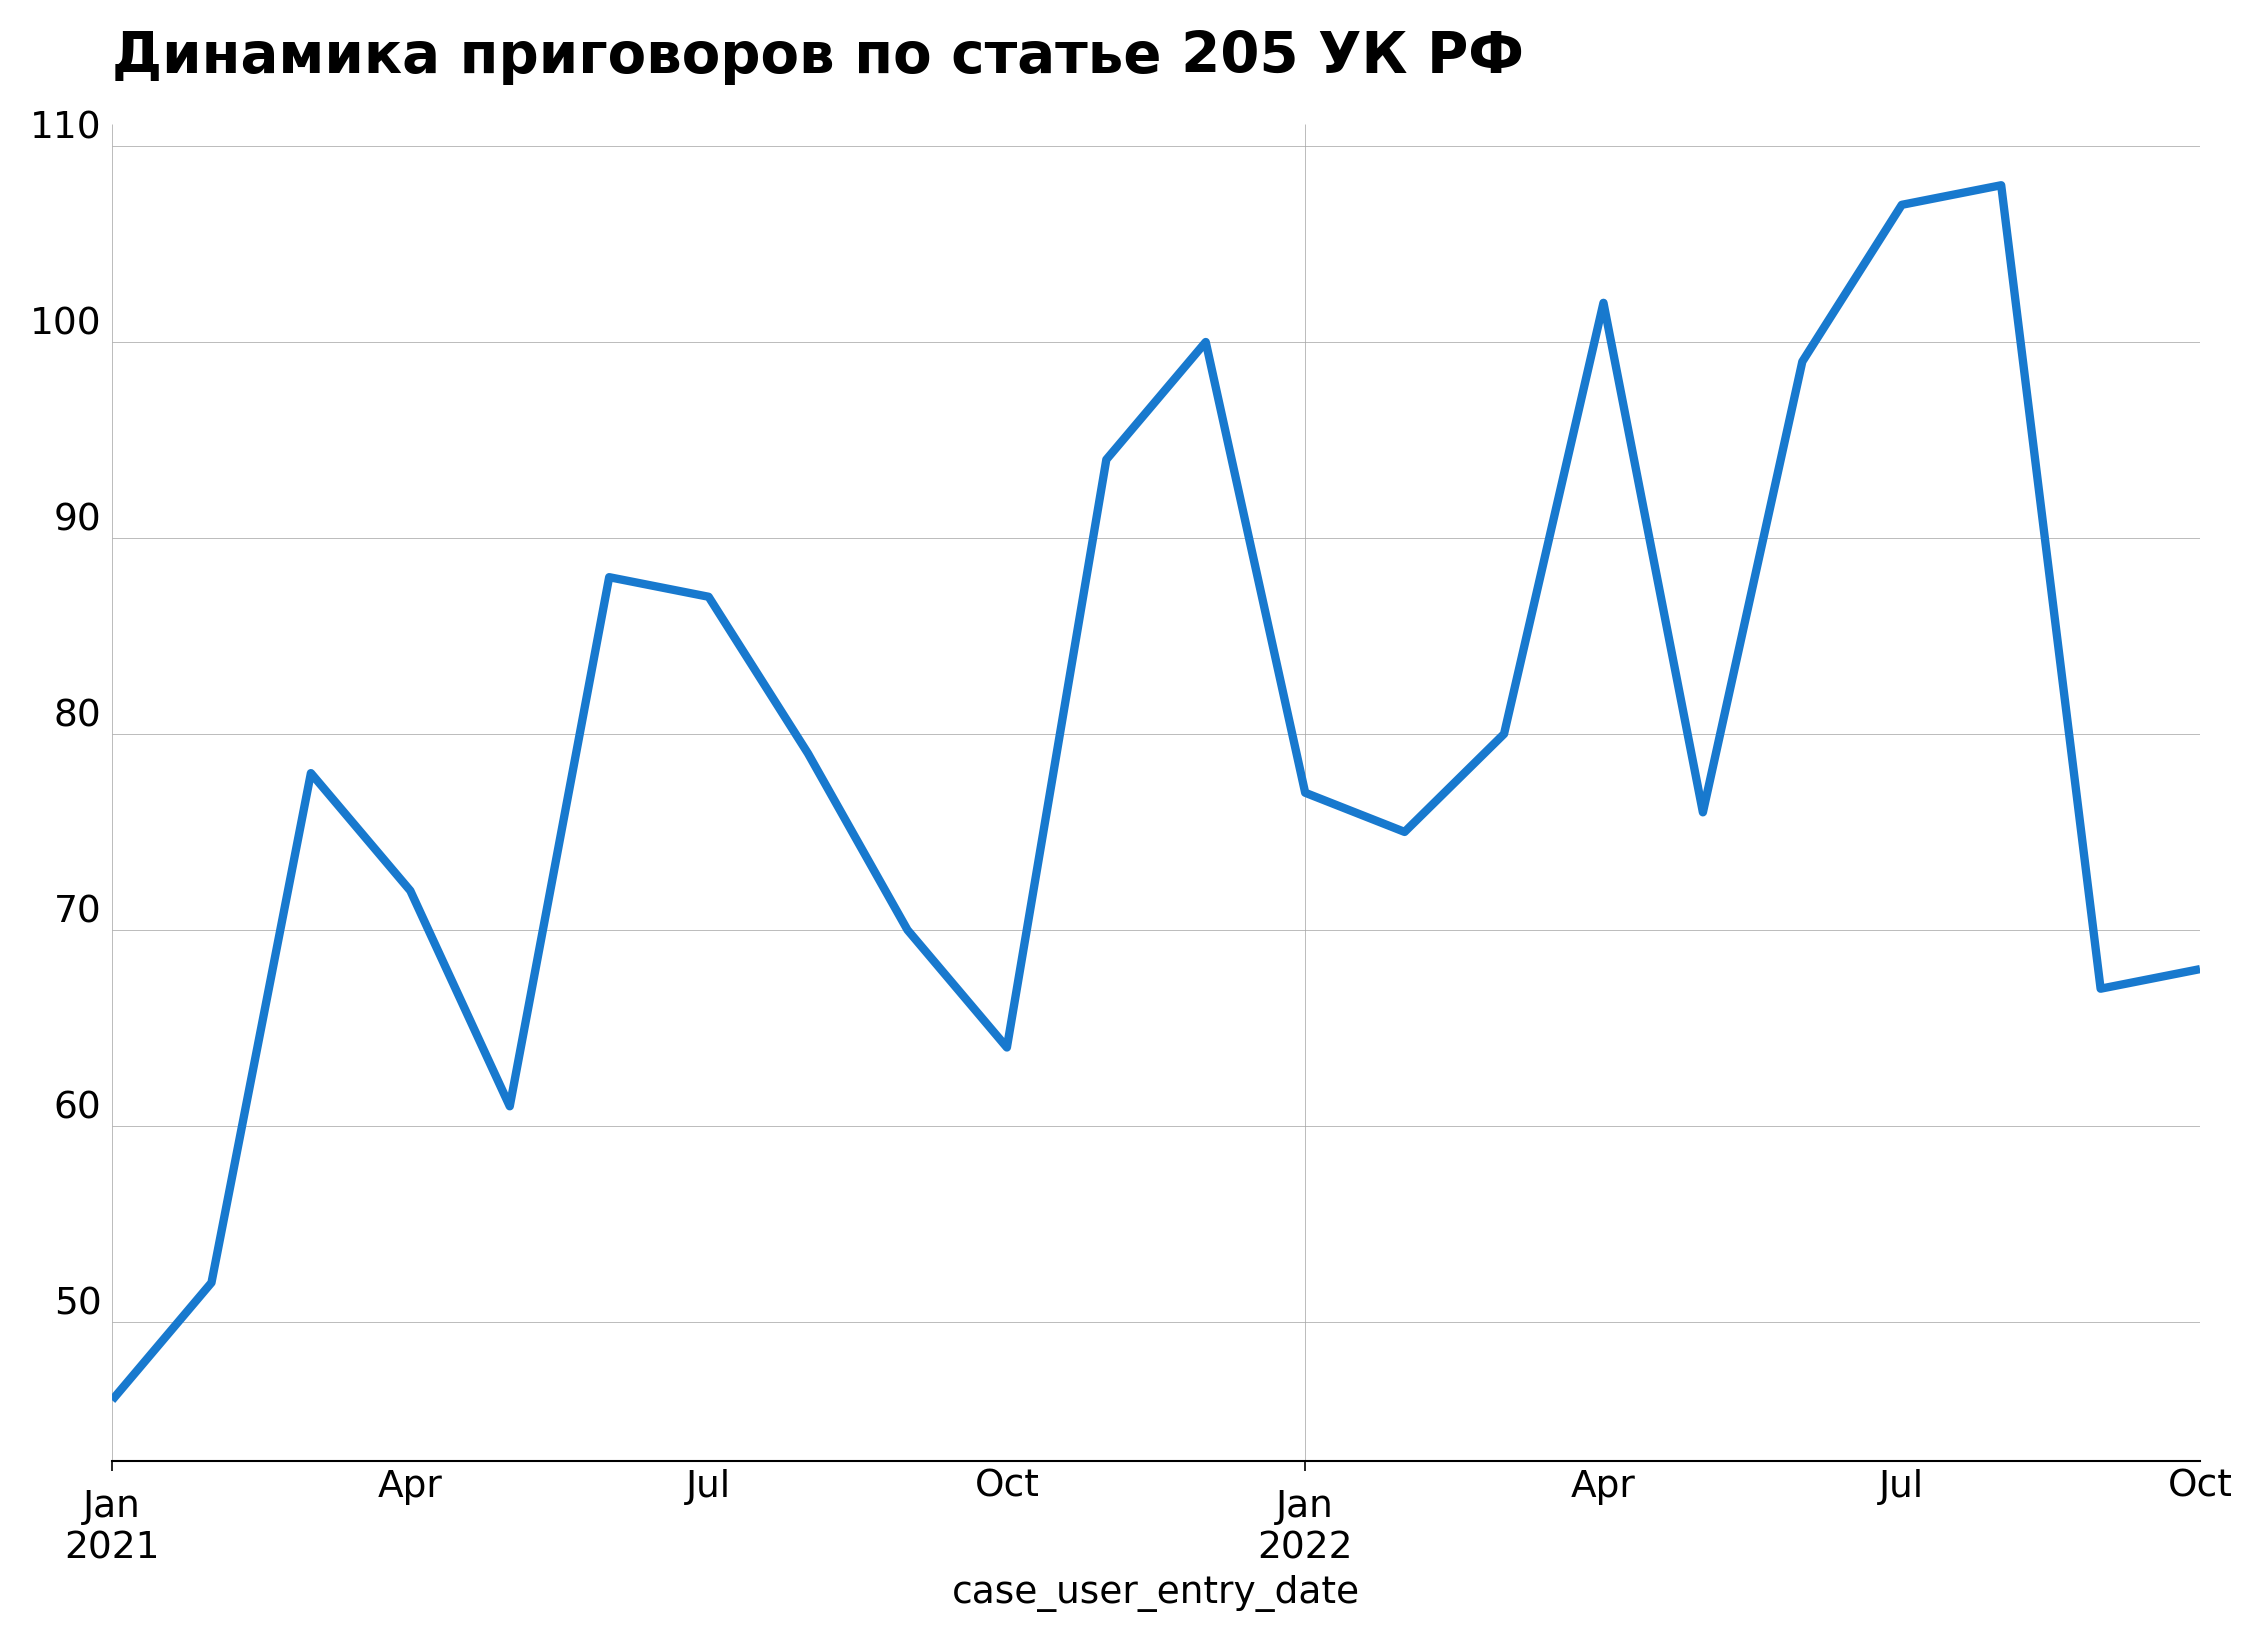

In [39]:
(
    df_short[df_short.article.str.contains('205')]
    .set_index('case_user_entry_date')
    .resample('m')
    .size()
    .plot()
    .set_title('Динамика приговоров по статье 205 УК РФ')
);

## 2022 - год женского протеста?

В прошлом году достаточно много писали о том, что антивоенный протест - это в первую очередь женский протест. И эта тенденция действительно видна в собранных данных.

In [55]:
df_short.groupby(['year','gender'], as_index=False).size()

year  gender  size
0  2021  Female  2080
1  2021    Male  8343
2  2022  Female  2771
3  2022    Male  8213

При том, что кол-во приговоров за 2021 и 2022 годы в датасете практически одинаково (отличается на 200 приговоров), против женщин в этом году возбуждено почти на 700 дел больше, чем в прошлом году. Для мужчин цифра практически не изменилась.

Рост дел произошёл в основном из-за административных статей. Уголовных дел стало даже меньше. Но это скорее всего связано с тем, что часть уголовных дел ещё не опубликованы на ГАС "Правосудии"

In [57]:
df_short.groupby(['year','gender', 'is_criminal']).size()

year  gender  is_criminal
2021  Female  0              1974
              1               106
      Male    0              7297
              1              1046
2022  Female  0              2705
              1                66
      Male    0              7219
              1               994
dtype: int64

## География приговоров

* Впереди всех по абсолютным цифрам в 2022 году - Санкт-Петербург. 
* В датасете нет Москвы, потому что судебные данные публикуются на другом сайте
* Интересно, что в топе есть Крым. В 2021 году его не было.

In [61]:
df_short[df_short.year == 2022] \
        .groupby('case_doc_subject_rf', as_index=False) \
        .size() \
        .sort_values(ascending=False, by='size')[:20]

case_doc_subject_rf  size
76          город Санкт-Петербург  2141
20             Краснодарский край   620
27             Московская область   481
47                Республика Крым   398
56              Самарская область   347
8             Воронежская область   306
36                  Пермский край   299
21              Красноярский край   295
31          Новосибирская область   277
14        Калининградская область   265
46                Республика Коми   256
69               Хабаровский край   240
71            Челябинская область   223
45             Республика Карелия   220
2           Архангельская область   191
18  Кемеровская область - Кузбасс   188
54             Ростовская область   186
7             Вологодская область   184
33           Оренбургская область   183
0                  Алтайский край   181